## Предсказание успешности стартапа (закроется или нет)

**Описание и цель проекта:**  

На основании данных о стартапах, функционировавших в период с 1970 по 2018 годы, необходимо разработать модель предсказывающую вероятность закрытия того или иного стартапа.

**Описание данных:**

Датасет состоит из двух файлов: тренировочный набор (около 53к записей) и тестовый набор (около 13к записей). Тренировочный набор содержит целевой признак status, указывающий на то, закрылся стартап или продолжает действовать. Временной период - '1970-01-01' по '2018-01-01'. Дата формирования выгрузки - '2018-01-01'

*kaggle_startups_train_01.csv* - информация (53 000) стартапах, которые будут использоваться в качестве обучающих данных.
*kaggle_startups_test_01.csv* - информация (13 000) стартапах, которые будут использоваться в качестве тестовых данных. Необходимо предсказать значение 'status' для каждого стартапа из этого датасета.
*kaggle_startups_sample_submit_01.csv* - файл с примером предсказаний в правильном формате.
name - идентификатор (название) стартапа в тестовом наборе.
status - целевой признак. Для каждого стартапа необходимо предсказать категориальное значение соответствующее прогнозу ['operating', 'closed'].

**Описание полей данных:**

*name* - Название стартапа  
*category_list* - Список категорий, к которым относится стартап  
*funding_total_usd* - Общая сумма финансирования в USD  
*status* - Статус стартапа (закрыт или действующий)  
*country_code* - Код страны  
*state_code* - Код штата  
*region* - Регион  
*city* - Город  
*funding_rounds* - Количество раундов финансирования  
*founded_at* - Дата основания  
*first_funding_at* - Дата первого раунда финансирования  
*last_funding_at* - Дата последнего раунда финансирования  
*closed_at* - Дата закрытия стартапа (если применимо)  
*lifetime* - Время существования стартапа в днях

In [258]:
!pip -q install catboost
!pip -q install shap
!pip -q install phik

In [259]:
# Импортируем необходимые для анализа библиотеки
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import (
    OneHotEncoder, OrdinalEncoder, LabelEncoder,
    StandardScaler, MinMaxScaler, RobustScaler
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.feature_selection import SelectKBest, chi2
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, precision_score, recall_score, make_scorer
import datetime
from datetime import timedelta
import shap
from phik import phik_matrix
from phik.report import plot_correlation_matrix
import warnings
warnings.filterwarnings('ignore')

In [260]:
# заводим нужные константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [261]:
# оптимизируем формат вывода
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.1f}'.format

## 1. Initializing data

In [262]:
import requests
from urllib.parse import urlencode

# используем api
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/FeON_q-3qPiggg'

# получаем url
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

# загружаем файл в df
download_response = requests.get(download_url)
data_train = pd.read_csv(download_url)

In [263]:
# используем api
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/8ynGXX8Cy9KJ8A'

# получаем url
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

# загружаем файл в df
download_response = requests.get(download_url)
data_test = pd.read_csv(download_url)

Выведем 10 случайных строк датасетов, для оценки корректности вывода

In [264]:
data_train.sample(10)

name  \
23838                ShoCard   
16532       PalsUniverse.com   
4070                  Quotfy   
1073              CeraCarbon   
23505            Fare Motion   
49953                Olocode   
45692   Primal Space Systems   
37904          Valeo Medical   
22204              Applixure   
5780   Janus Biotherapeutics   

                                           category_list  funding_total_usd  \
23838                                    Mobile Commerce          1500000.0   
16532                                         Networking                NaN   
4070          Services|Social Media|Social Network Media           750000.0   
1073                                       Manufacturing            16227.0   
23505                                  Automotive|Mobile                NaN   
49953                                           Software           454575.0   
45692                                         Technology          2999997.0   
37904                                      Biotechnology          1000000.0   
22204  Application Performance Monitoring|Business Pr...           462166.2   
5780                                       Biotechnology          1600000.0   

          status country_code state_code       region        city  \
23838  operating          USA         CA  SF Bay Area   Palo Alto   
16532  operating          CAN         SK   SK - Other     Estevan   
4070   operating          IRL          7       Dublin      Dublin   
1073   operating          NLD         11  NLD - Other       Stein   
23505  operating          NaN        NaN          NaN         NaN   
49953  operating          GBR         H9       London      London   
45692  operating          USA         NC      Raleigh     Raleigh   
37904  operating          USA         MA       Boston  Burlington   
22204  operating          FIN         13     Helsinki    Helsinki   
5780   operating          USA         MA       Boston   Cambridge   

       funding_rounds  founded_at first_funding_at last_funding_at closed_at  
23838               1  2015-02-03       2015-07-17      2015-07-17       NaN  
16532               1  2014-02-09       2014-04-16      2014-04-16       NaN  
4070                1  2014-10-10       2014-10-28      2014-10-28       NaN  
1073                1  2015-01-01       2015-03-31      2015-03-31       NaN  
23505               1  2013-01-01       2013-01-01      2013-01-01       NaN  
49953               1  2012-01-01       2013-06-17      2013-06-17       NaN  
45692               1  1997-01-01       2015-08-17      2015-08-17       NaN  
37904               1  2003-01-01       2013-05-09      2013-05-09       NaN  
22204               1  2012-12-01       2013-01-01      2013-01-01       NaN  
5780                2  2010-01-01       2011-03-16      2011-08-19       NaN

In [265]:
data_test.sample(10)

name                                    category_list  \
482             One On One                              Sales and Marketing   
8407              GiggedIn  Artists Globally|Innovation Management|Services   
12004     Twych Innovation                                              NaN   
5159               Gemfire  Manufacturing|Semiconductors|Telecommunications   
12519                  RE2                                          Defense   
11073              G.ho.st                      Cloud Computing|Web Hosting   
11312              Novitas                              Security|Technology   
5542              AlaMarka                             E-Commerce|Lifestyle   
7990   TAKEASY CORPORATION        E-Commerce|Q&A|SEO|Social Media Platforms   
10901          iWABOO Inc.                                              NaN   

       funding_total_usd country_code state_code       region        city  \
482             750000.0          USA         MO    St. Louis    St Louis   
8407            962962.0          AUS          2       Sydney      Sydney   
12004                NaN          USA         CA   CA - Other    Oak Park   
5159         100000000.0          USA         CA  SF Bay Area     Fremont   
12519          2250000.0          USA         PA   Pittsburgh  Pittsburgh   
11073          3000000.0          ISR          6     Tel Aviv   Jerusalem   
11312          1600000.0          FRA         97  FRA - Other       Aydie   
5542           1000000.0          NaN        NaN          NaN         NaN   
7990             27500.0          NaN        NaN          NaN         NaN   
10901           650640.7          NaN        NaN          NaN         NaN   

       funding_rounds first_funding_at last_funding_at  lifetime  
482                 1       2014-06-04      2014-06-04      1544  
8407                2       2014-04-01      2015-07-01      2192  
12004               1       2015-01-02      2015-01-02      1096  
5159                2       2001-03-05      2007-09-01      8401  
12519               2       2014-01-29      2014-08-18      6209  
11073               1       2008-05-29      2008-05-29      1273  
11312               1       2014-08-20      2014-08-20      1757  
5542                1       2010-09-01      2010-09-01      2829  
7990                1       2014-04-15      2014-04-15      1664  
10901               1       2013-06-03      2013-06-03       792

Как видно, вцелом данные  отображаются корректно. Тренировочная и тестовая выборки имеют различия в признаковом описании (помимо наличия/отсутствия целевого признака). Также столбец 'category_list' содержит излишне многоуровневое описание. Разберемся с данными вопросами в разделах ниже. Пока выведем общую информацию о загруженных датасетах:

In [266]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


In [267]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


Как видно, столбцы обоих датасетов имеют значительное количество пропусков, обработку которых выполним в разделе ниже. Также обратим внимание, что значения даты имеют строковый тип данных, на данный момент оставим их в таком виде, т.к. многие модели классификации не работают с данными типа date/datetime.

Выведем основные статистические характеристики датафреймов:

In [268]:
data_train.describe().T

count       mean         std  min      25%       50%  \
funding_total_usd 42447.0 18247480.7 187117301.3  1.0 336027.5 2000000.0   
funding_rounds    52516.0        1.7         1.4  1.0      1.0       1.0   

                         75%           max  
funding_total_usd 10000000.0 30079503000.0  
funding_rounds           2.0          19.0

In [269]:
data_test.describe().T

count       mean        std  min      25%       50%  \
funding_total_usd 10547.0 16549102.7 92172825.6  1.0 320000.0 2000000.0   
funding_rounds    13125.0        1.7        1.3  1.0      1.0       1.0   
lifetime          13125.0     3097.6     2128.4 52.0   1726.0    2526.0   

                         75%          max  
funding_total_usd 10000000.0 4715000000.0  
funding_rounds           2.0         15.0  
lifetime              3866.0      17167.0

**Вывод:** Необходимые для исследования данные загружены, проверены на корректность отображения, также выведены основные статистические параметры датасетов.


# 2. Preprocessing

Вернемся к вопросу различий в признаковом описании тренировочной и тестовой выборок:

In [270]:
data_train.head()

name                          category_list  \
0               Lunchgate        Online Reservations|Restaurants   
1                 EarLens  Manufacturing|Medical|Medical Devices   
2  Reviva Pharmaceuticals                          Biotechnology   
3    Sancilio and Company                            Health Care   
4     WireTough Cylinders                          Manufacturing   

   funding_total_usd     status country_code state_code       region  \
0           828626.0  operating          CHE         25       Zurich   
1         42935019.0  operating          USA         CA  SF Bay Area   
2         35456381.0  operating          USA         CA  SF Bay Area   
3         22250000.0  operating          NaN        NaN          NaN   
4                NaN  operating          USA         VA   VA - Other   

           city  funding_rounds  founded_at first_funding_at last_funding_at  \
0        Zürich               2  2009-10-17       2011-05-01      2014-12-01   
1  Redwood City               4  2005-01-01       2010-05-04      2014-02-25   
2      San Jose               3  2006-01-01       2012-08-20      2014-07-02   
3           NaN               3  2004-01-01       2011-09-01      2014-07-18   
4       Bristol               1  2010-05-12       2012-02-01      2012-02-01   

  closed_at  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN

In [271]:
data_test.head()

name                   category_list  funding_total_usd  \
0              Crystalsol                Clean Technology          2819200.0   
1        JBI Fish & Wings                     Hospitality                NaN   
2                COINPLUS                         Finance           428257.0   
3  Imagine Communications  Software|Video|Video Streaming         34700000.0   
4                   DNA13                        Software          4530000.0   

  country_code state_code            region              city  funding_rounds  \
0          NIC         17               NaN               NaN               1   
1          USA         TN        TN - Other          Humboldt               1   
2          LUX          3  Esch-sur-alzette  Esch-sur-alzette               2   
3          USA         CA         San Diego         San Diego               4   
4          CAN         ON            Ottawa            Ottawa               1   

  first_funding_at last_funding_at  lifetime  
0       2009-07-01      2009-07-01      3501  
1       2010-07-28      2010-07-28      2717  
2       2014-05-15      2014-09-18      1295  
3       2005-01-01      2010-04-20      4748  
4       2007-05-08      2007-05-08      6209

Обратим внимание, что помимо отсутствующего в тестовой выборке столбца 'status' (что логично, т.к. это целевой признак), датасеты различаются наличием в тренировочной выборке столбцов 'founded_at' (дата основания стартапа) и 'closed_at' (дата закрытия стартапа). В свою очередь тестовая выборка содержит отсутутсвующий в тренировочной выборке столбец 'lifetime' (время существования стартапа в днях).
Столбец 'closed_at' содержит огромное количество пропусков, поэтому в целях избавления от этих пропусков, а также в целях приведения тренировочной и тестовой выборки к единобразной структуре, создадим столбец 'lifetime' для тренировочной выборки. Нам известно, что дата формирования выгрузки - '2018-01-01', заполним данным значением пропуски в столбце 'closed_at' и  если мы от этого столбца вычтем значения столбца 'founded_at', то получим искомое время существования стартапа. После создания столбца 'lifetime' в тренировочной выборке, столбцы 'founded_at'  и 'closed_at' удалим.

In [272]:
data_train['closed_at'] = data_train['closed_at'].fillna('2018-01-01')

In [273]:
data_train['lifetime'] = (
    pd.to_datetime(data_train['closed_at']) -
     pd.to_datetime(data_train['founded_at'])
).dt.days

In [274]:
data_train = data_train.drop(['closed_at', 'founded_at'], axis=1)

In [275]:
data_train.head()

name                          category_list  \
0               Lunchgate        Online Reservations|Restaurants   
1                 EarLens  Manufacturing|Medical|Medical Devices   
2  Reviva Pharmaceuticals                          Biotechnology   
3    Sancilio and Company                            Health Care   
4     WireTough Cylinders                          Manufacturing   

   funding_total_usd     status country_code state_code       region  \
0           828626.0  operating          CHE         25       Zurich   
1         42935019.0  operating          USA         CA  SF Bay Area   
2         35456381.0  operating          USA         CA  SF Bay Area   
3         22250000.0  operating          NaN        NaN          NaN   
4                NaN  operating          USA         VA   VA - Other   

           city  funding_rounds first_funding_at last_funding_at  lifetime  
0        Zürich               2       2011-05-01      2014-12-01      2998  
1  Redwood City               4       2010-05-04      2014-02-25      4748  
2      San Jose               3       2012-08-20      2014-07-02      4383  
3           NaN               3       2011-09-01      2014-07-18      5114  
4       Bristol               1       2012-02-01      2012-02-01      2791

Признаковое описание тренировочной выборки, теперь соответствует тестовой. Далее обработаем пропуски

In [276]:
data_train.isna().sum()

name                     1
category_list         2465
funding_total_usd    10069
status                   0
country_code          5502
state_code            6763
region                6359
city                  6359
funding_rounds           0
first_funding_at         0
last_funding_at          0
lifetime                 0
dtype: int64

In [277]:
data_test.isna().sum()

name                    0
category_list         591
funding_total_usd    2578
country_code         1382
state_code           1695
region               1589
city                 1587
funding_rounds          0
first_funding_at        0
last_funding_at         0
lifetime                0
dtype: int64

Пропуски в столбцах с категориальными данными заменим на 'unknown', т.к. у нас отсутствует возможность каким то образом восстановить отсутствующие данные.

In [278]:
data_train['name'] = data_train['name'].fillna('unknown')
data_train['category_list'] = data_train['category_list'].fillna('unknown')
data_train['country_code'] = data_train['country_code'].fillna('unknown')
data_train['state_code']= data_train['state_code'].fillna('unknown')
data_train['region'] = data_train['region'].fillna('unknown')
data_train['city'] = data_train['city'].fillna('unknown')

In [279]:
data_test['name'] = data_test['name'].fillna('unknown')
data_test['category_list'] = data_test['category_list'].fillna('unknown')
data_test['country_code'] = data_test['country_code'].fillna('unknown')
data_test['state_code']= data_test['state_code'].fillna('unknown')
data_test['region'] = data_test['region'].fillna('unknown')
data_test['city'] = data_test['city'].fillna('unknown')

Пропуски в столбцах с количественными данными ('funding_total_usd') заменим на медиану общей суммы финансирования, по категории деятельности ('category_list'), к которой относится стартап.

In [280]:
data_train['funding_total_usd'] = data_train['funding_total_usd'].fillna(data_train['funding_total_usd'].median())

In [281]:
data_test['funding_total_usd'] = data_test['funding_total_usd'].fillna(data_test['funding_total_usd'].median())

In [282]:
data_train.isna().sum()

name                 0
category_list        0
funding_total_usd    0
status               0
country_code         0
state_code           0
region               0
city                 0
funding_rounds       0
first_funding_at     0
last_funding_at      0
lifetime             0
dtype: int64

In [283]:
data_test.isna().sum()

name                 0
category_list        0
funding_total_usd    0
country_code         0
state_code           0
region               0
city                 0
funding_rounds       0
first_funding_at     0
last_funding_at      0
lifetime             0
dtype: int64

Проверим тренировочный датасет на наличие явных дубликатов (тренировочный проверять бессмысленно, так как исходя из условий задания,  даже если дубликаты в нем будут выявлены, удалить их мы не можем)

In [284]:
data_train.duplicated().sum()

0

In [285]:
data_train.duplicated('name').sum()

0

Вернемся к параметрам даты 'first_funding_at' и 'last_funding_at' представленных строковым типом данных. Чтобы увеличить обобщающую способность модели, округлим значения данных параметров до значения года, в котором проходил соответствующий инвестраунд и преобразуем результат в целочисленный формат

In [286]:
data_train['first_funding_at'] = data_train['first_funding_at'].astype(str)

In [287]:
for i in range(len(data_train)):
    data_train['first_funding_at'][i] = data_train['first_funding_at'][i].split('-')[0]

In [288]:
data_train['first_funding_at'] = data_train['first_funding_at'].astype(int)

In [289]:
data_test['first_funding_at'] = data_test['first_funding_at'].astype(str)

In [290]:
for i in range(len(data_test)):
    data_test['first_funding_at'][i] = data_test['first_funding_at'][i].split('-')[0]

In [291]:
data_test['first_funding_at'] = data_test['first_funding_at'].astype(int)

In [292]:
data_train['last_funding_at'] = data_train['last_funding_at'].astype(str)

In [293]:
for i in range(len(data_train)):
    data_train['last_funding_at'][i] = data_train['last_funding_at'][i].split('-')[0]

In [294]:
data_train['last_funding_at'] = data_train['last_funding_at'].astype(int)

In [295]:
data_test['last_funding_at'] = data_test['last_funding_at'].astype(str)

In [296]:
for i in range(len(data_test)):
    data_test['last_funding_at'][i] = data_test['last_funding_at'][i].split('-')[0]

In [297]:
data_test['last_funding_at'] = data_test['last_funding_at'].astype(int)

In [298]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52516 non-null  object 
 1   category_list      52516 non-null  object 
 2   funding_total_usd  52516 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       52516 non-null  object 
 5   state_code         52516 non-null  object 
 6   region             52516 non-null  object 
 7   city               52516 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   first_funding_at   52516 non-null  int64  
 10  last_funding_at    52516 non-null  int64  
 11  lifetime           52516 non-null  int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 4.8+ MB


In [299]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      13125 non-null  object 
 2   funding_total_usd  13125 non-null  float64
 3   country_code       13125 non-null  object 
 4   state_code         13125 non-null  object 
 5   region             13125 non-null  object 
 6   city               13125 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  int64  
 9   last_funding_at    13125 non-null  int64  
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 1.1+ MB


В столбце 'category_list' имеются многоуровневые наименования категорий деятельности компании. Посмотрим сколько уникальных значений содержит данный столбец:

In [300]:
len(data_train['category_list'].value_counts())

22106

Как видно столбец 'category_list' содержит большое количество уникальных значений, что скорее всего помешает модели найти какие то закономерности между данным признаком и таргетом. Выделим из многоуровнего списка категорий, категорию первого уровня и присвоим данное значение объекту:

In [301]:
for i in range(len(data_train)):
    data_train['category_list'][i] = data_train['category_list'][i].split('|')[0]

 Посмотрим сколько уникальных значений содержит столбец 'category_list' после проведенной замены:

In [302]:
len(data_train['category_list'].unique())

708

За счет данной замены получилось существенно снизить количество категорий. Выполним аналогичную операцию для тестовой выборки:

In [303]:
len(data_test['category_list'].unique())

6207

In [304]:
for i in range(len(data_test)):
    data_test['category_list'][i] = data_test['category_list'][i].split('|')[0]

In [305]:
len(data_test['category_list'].unique())

560

Определим насколько часто категории определенные нами для тренировочной выборки, встречаются в тестовой выборке

In [306]:
len(np.intersect1d(data_train['category_list'].unique(), data_test['category_list'].unique()))

540

Как видно из анализа выше, большая часть категорий деятельности стартапов встречается в обеих выборках. Далее изучим количество уникальных значений по другим столбцам с категориальными значениями данных:

In [307]:
len(data_train['country_code'].unique())

135

In [308]:
len(data_test['country_code'].unique())

97

In [309]:
len(data_train['state_code'].unique())

301

In [310]:
len(data_test['state_code'].unique())

236

In [311]:
len(data_train['region'].unique())

1037

In [312]:
len(data_test['region'].unique())

689

In [313]:
len(data_train['city'].unique())

4478

In [314]:
len(data_test['city'].unique())

2118

Сократим количество уникальных значений для категориальных значений, для улучшения обобщающей способности модели.
Отберем наиболее частые категории, остальным присвоим значение 'Other'

In [315]:
category_freq = (data_train['category_list'].value_counts())/data_train.shape[0]
bottom_threshold = category_freq.quantile(q=0.5)
less_freq_categories = category_freq[category_freq <= bottom_threshold]
data_train['category_list'].loc[data_train['category_list'].isin(less_freq_categories.index.tolist())] = 'Other'

In [316]:
category_freq = (data_test['category_list'].value_counts())/data_test.shape[0]
bottom_threshold = category_freq.quantile(q=0.5)
less_freq_categories = category_freq[category_freq <= bottom_threshold]
data_test['category_list'].loc[data_test['category_list'].isin(less_freq_categories.index.tolist())] = 'Other'

In [317]:
len(data_train['category_list'].unique())

343

In [318]:
len(data_test['category_list'].unique())

259

In [319]:
category_freq = (data_train['country_code'].value_counts())/data_train.shape[0]
bottom_threshold = category_freq.quantile(q=0.85)
less_freq_categories = category_freq[category_freq <= bottom_threshold]
data_train['country_code'].loc[data_train['country_code'].isin(less_freq_categories.index.tolist())] = 'Other'

In [320]:
category_freq = (data_test['country_code'].value_counts())/data_test.shape[0]
bottom_threshold = category_freq.quantile(q=0.85)
less_freq_categories = category_freq[category_freq <= bottom_threshold]
data_test['country_code'].loc[data_test['country_code'].isin(less_freq_categories.index.tolist())] = 'Other'

In [321]:
len(data_train['country_code'].unique())

22

In [322]:
len(data_test['country_code'].unique())

16

In [323]:
category_freq = (data_train['state_code'].value_counts())/data_train.shape[0]
bottom_threshold = category_freq.quantile(q=0.85)
less_freq_categories = category_freq[category_freq <= bottom_threshold]
data_train['state_code'].loc[data_train['state_code'].isin(less_freq_categories.index.tolist())] = 'Other'

In [324]:
category_freq = (data_test['state_code'].value_counts())/data_test.shape[0]
bottom_threshold = category_freq.quantile(q=0.85)
less_freq_categories = category_freq[category_freq <= bottom_threshold]
data_test['state_code'].loc[data_test['state_code'].isin(less_freq_categories.index.tolist())] = 'Other'

In [325]:
len(data_train['state_code'].unique())

46

In [326]:
len(data_test['state_code'].unique())

37

In [327]:
category_freq = (data_train['region'].value_counts())/data_train.shape[0]
bottom_threshold = category_freq.quantile(q=0.85)
less_freq_categories = category_freq[category_freq <= bottom_threshold]
data_train['region'].loc[data_train['region'].isin(less_freq_categories.index.tolist())] = 'Other'

In [328]:
category_freq = (data_test['region'].value_counts())/data_test.shape[0]
bottom_threshold = category_freq.quantile(q=0.85)
less_freq_categories = category_freq[category_freq <= bottom_threshold]
data_test['region'].loc[data_test['region'].isin(less_freq_categories.index.tolist())] = 'Other'

In [329]:
len(data_train['region'].unique())

153

In [330]:
len(data_test['region'].unique())

105

In [331]:
category_freq = (data_train['city'].value_counts())/data_train.shape[0]
bottom_threshold = category_freq.quantile(q=0.85)
less_freq_categories = category_freq[category_freq <= bottom_threshold]
data_train['city'].loc[data_train['city'].isin(less_freq_categories.index.tolist())] = 'Other'

In [332]:
category_freq = (data_test['city'].value_counts())/data_test.shape[0]
bottom_threshold = category_freq.quantile(q=0.85)
less_freq_categories = category_freq[category_freq <= bottom_threshold]
data_test['city'].loc[data_test['city'].isin(less_freq_categories.index.tolist())] = 'Other'

In [333]:
len(data_train['city'].unique())

628

In [334]:
len(data_test['city'].unique())

305

**Вывод:**   
В рамках данного раздела:
- выявлены и обработаны пропуски в количественных и категориальных данных;
- тренировочный датасет проверен на наличие явных дубликатов и дубликатов по названию компании;
- значения, отображающие даты событий, переведены из строкового формата в формат datetime;
- сокращено количество уникальных значений категориальных признаков, для улучшения обобщающей способности модели

# 3. EDA

Рассмотрим подробнее распределение значений количественных и категориальных значений входящих признаков. Для построения графиков описывающих такое распределение, будем использовать следующие функции:

In [335]:
# функция для количественных значений
def num_stat_and_graph(df, col, n, title):
    stat = df[col].describe()
    fig, axes = plt.subplots(1,2, figsize=(15,5))
    sns.histplot(df[col], bins=n, ax=axes[0])
    sns.boxplot(data=df, x=col)
    fig.suptitle(title);
    return stat

In [336]:
# функция для категориальных значений
def count_graph(df, col, name, a, b):
    fig, ax = plt.subplots(figsize=(a,b))
    ax = sns.countplot(y=df[col],
         order=df[col].value_counts(ascending=False).index);
    abs_values = df[col].value_counts(ascending=False).values
    ax.bar_label(container=ax.containers[0], labels=abs_values)
    ax.set_title(name);

Начнем с признаков тренировочной выборки, для удобства выведем первые пять строк датасета:

In [337]:
data_train.head()

name        category_list  funding_total_usd     status  \
0               Lunchgate  Online Reservations           828626.0  operating   
1                 EarLens        Manufacturing         42935019.0  operating   
2  Reviva Pharmaceuticals        Biotechnology         35456381.0  operating   
3    Sancilio and Company          Health Care         22250000.0  operating   
4     WireTough Cylinders        Manufacturing          2000000.0  operating   

  country_code state_code       region          city  funding_rounds  \
0          CHE      Other       Zurich        Zürich               2   
1          USA         CA  SF Bay Area  Redwood City               4   
2          USA         CA  SF Bay Area      San Jose               3   
3      unknown    unknown      unknown       unknown               3   
4          USA         VA        Other       Bristol               1   

   first_funding_at  last_funding_at  lifetime  
0              2011             2014      2998  
1              2010             2014      4748  
2              2012             2014      4383  
3              2011             2014      5114  
4              2012             2012      2791

Изучим распределение количественного параметра 'funding_total_usd'

count         52516.0
mean       15132318.0
std       168346591.4
min               1.0
25%          529721.2
50%         2000000.0
75%         6788929.0
max     30079503000.0
Name: funding_total_usd, dtype: float64

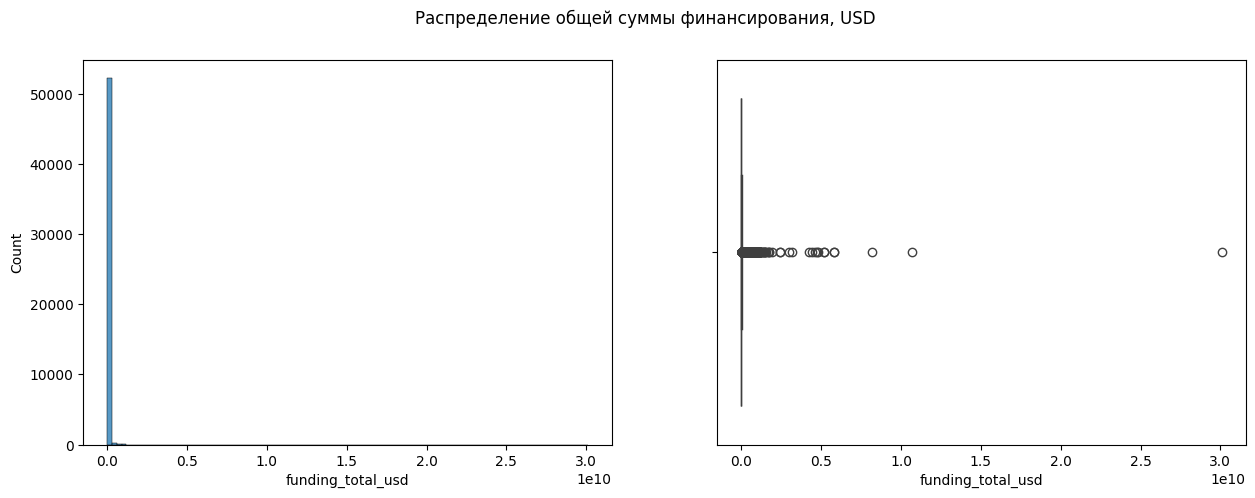

In [338]:
num_stat_and_graph(data_train, 'funding_total_usd', 100, 'Распределение общей суммы финансирования, USD')

Как видно из таблицы выше, значения параметра 'funding_total_usd' имеют весьма значительный  размах значений от 0 до 30_079_503_000, ввиду чего, графики выше смотрятся неиформативными. Для лучшего понимания распределения параметра, рассмотрим гистограмму на различных диапазонах его значений:

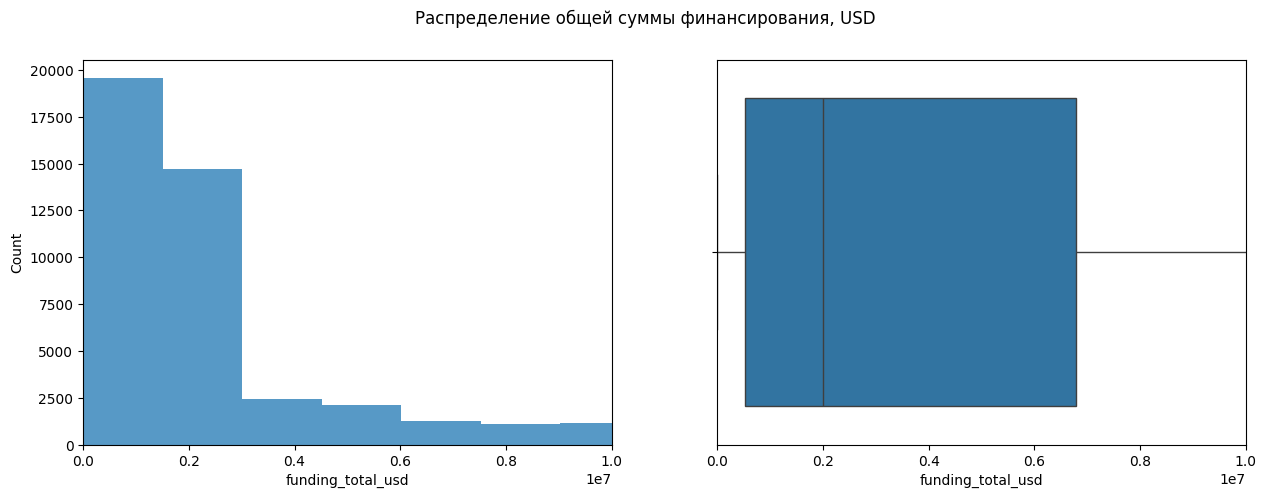

In [339]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
sns.histplot(data_train['funding_total_usd'], bins=20000, ax = axes[0])
axes[0].set_xlim(0,10_000_000)
sns.boxplot(data=data_train, x= 'funding_total_usd')
axes[1].set_xlim(0,10_000_000)
fig.suptitle('Распределение общей суммы финансирования, USD');

Как видно из гистограммы выше, большинство значений параметра находятся в дипазоне знеачений от 0 до 3_000_000

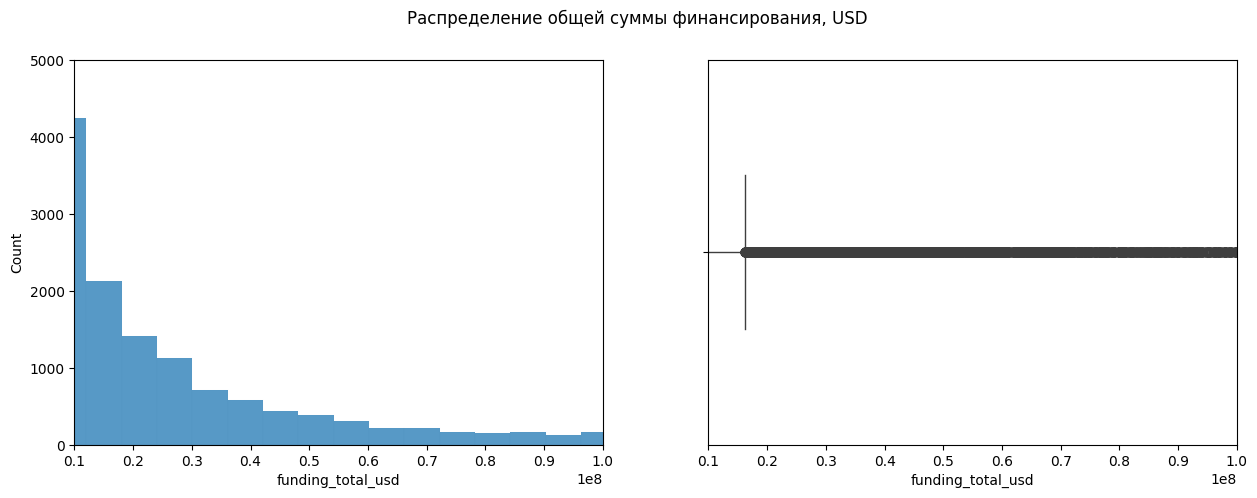

In [340]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
sns.histplot(data_train['funding_total_usd'], bins=5000, ax = axes[0])
axes[0].set_xlim(10_000_000,100_000_000)
axes[0].set_ylim(0,5000)
sns.boxplot(data=data_train, x= 'funding_total_usd')
axes[1].set_xlim(10_000_000,100_000_000)
fig.suptitle('Распределение общей суммы финансирования, USD');

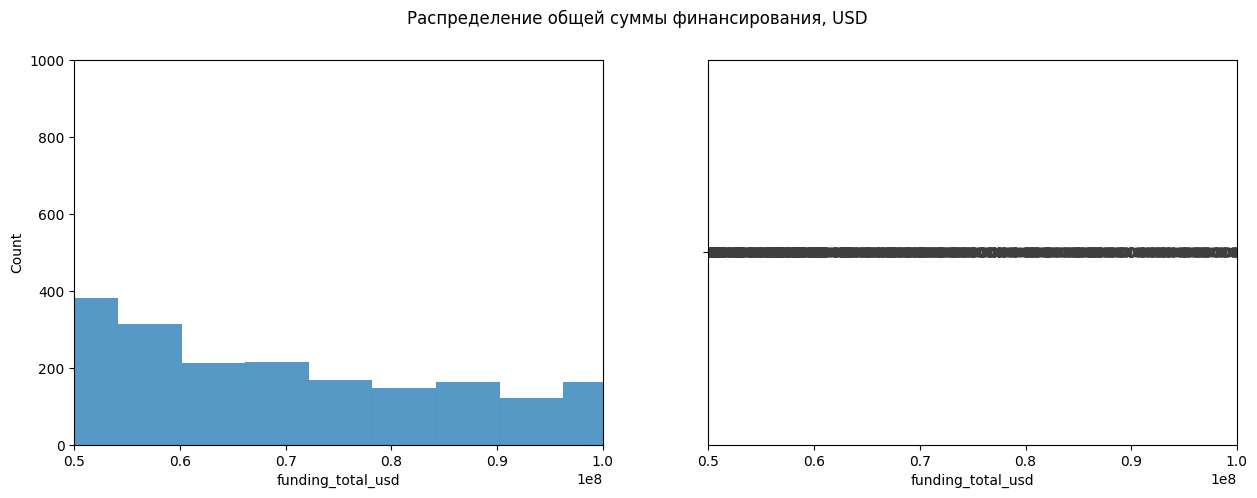

In [341]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
sns.histplot(data_train['funding_total_usd'], bins=5000, ax = axes[0])
axes[0].set_xlim(50_000_000,100_000_000)
axes[0].set_ylim(0,1000)
sns.boxplot(data=data_train, x= 'funding_total_usd')
axes[1].set_xlim(50_000_000,100_000_000)
fig.suptitle('Распределение общей суммы финансирования, USD');

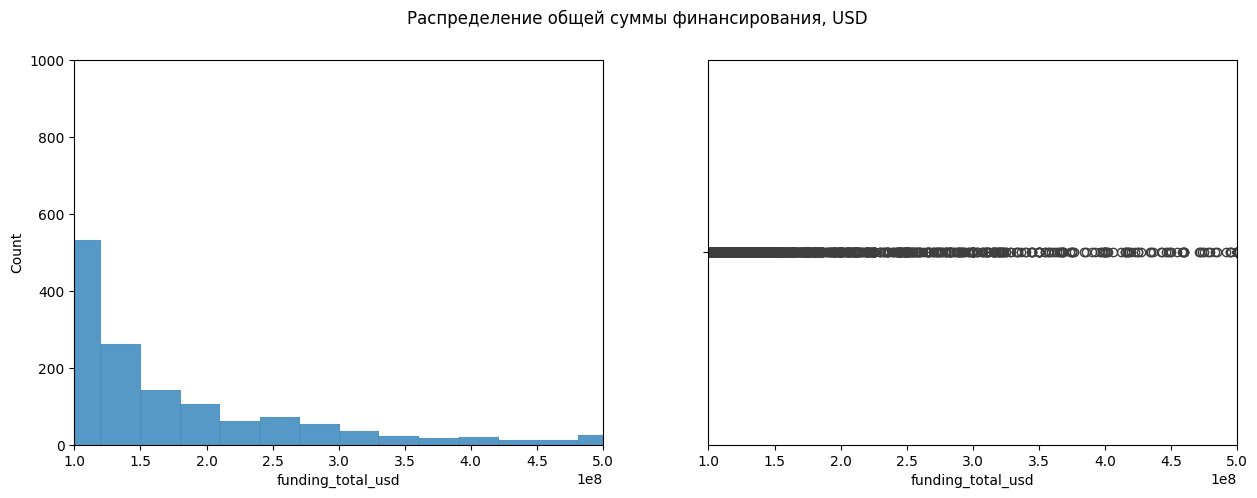

In [342]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
sns.histplot(data_train['funding_total_usd'], bins=1000, ax = axes[0])
axes[0].set_xlim(100_000_000,500_000_000)
axes[0].set_ylim(0,1000)
sns.boxplot(data=data_train, x= 'funding_total_usd')
axes[1].set_xlim(100_000_000,500_000_000)
fig.suptitle('Распределение общей суммы финансирования, USD');

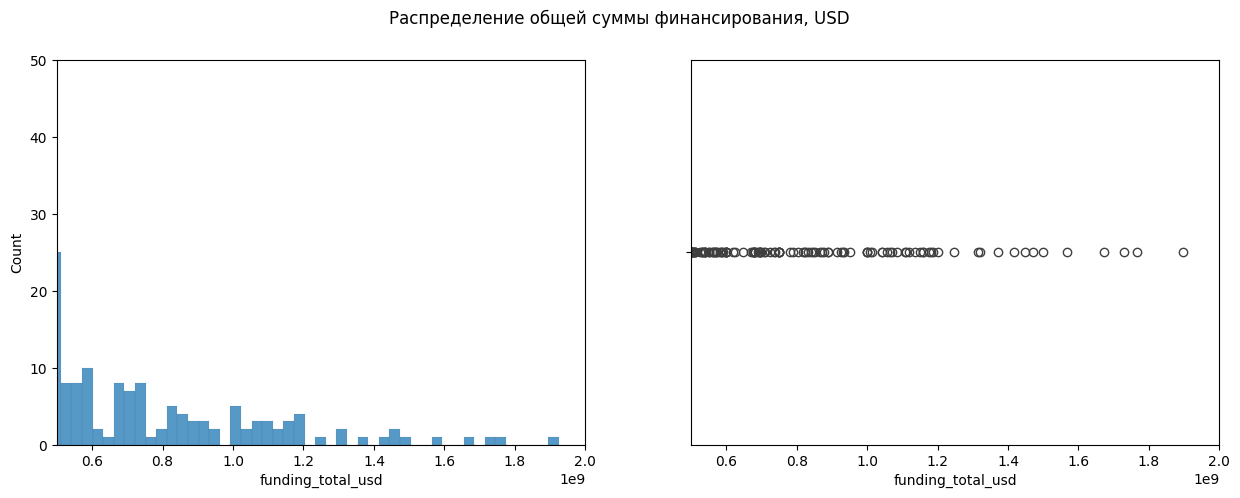

In [343]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
sns.histplot(data_train['funding_total_usd'], bins=1000, ax = axes[0])
axes[0].set_xlim(500_000_000,2_000_000_000)
axes[0].set_ylim(0,50)
sns.boxplot(data=data_train, x= 'funding_total_usd')
axes[1].set_xlim(500_000_000,2_000_000_000)
fig.suptitle('Распределение общей суммы финансирования, USD');

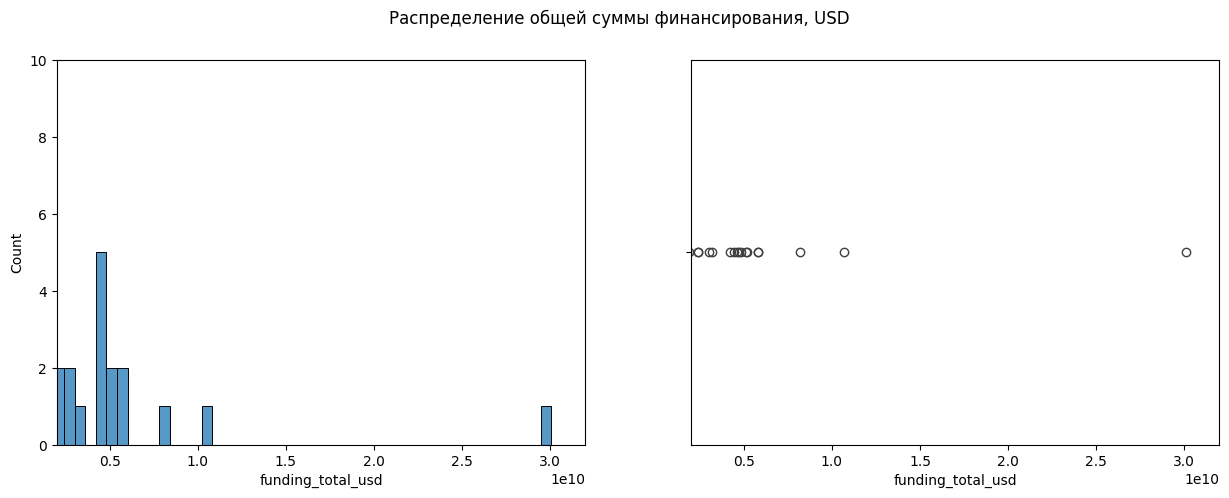

In [344]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
sns.histplot(data_train['funding_total_usd'], bins=50, ax = axes[0])
axes[0].set_xlim(2_000_000_000,32_000_000_000)
axes[0].set_ylim(0,10)
sns.boxplot(data=data_train, x= 'funding_total_usd')
axes[1].set_xlim(2_000_000_000,32_000_000_000)
fig.suptitle('Распределение общей суммы финансирования, USD');

Как видно из графиков выше, количество компаний, общая сумма финансирования которых превышает 2_000_000_000 USD незначительно, при этои они являются весьма существенными выбросами. Однако, опытным путем установлено, что их удаление снижает искомую в данном проекте метрику f1, в всязи с чем оставляем значения столбца  'funding_total_usd' в исходном виде. Далее изучим распределение параметра 'funding_round':

count   52516.0
mean        1.7
std         1.4
min         1.0
25%         1.0
50%         1.0
75%         2.0
max        19.0
Name: funding_rounds, dtype: float64

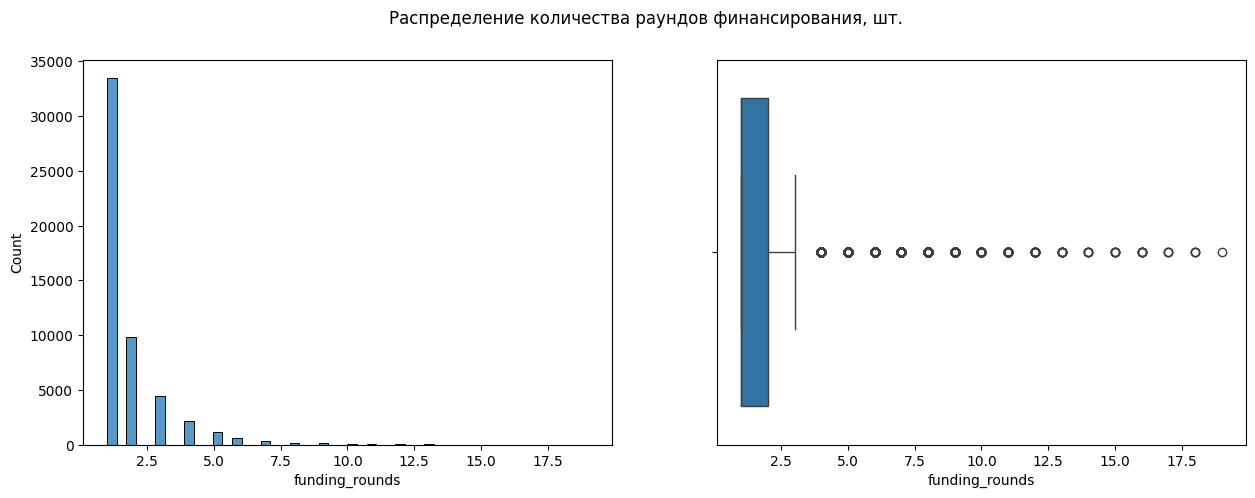

In [345]:
num_stat_and_graph(data_train, 'funding_rounds', 50, 'Распределение количества раундов финансирования, шт.')

Несмотря на тот факт, что "ящик с усами" считает все значения более 3-х - выбросами, нет оснований для удаления этих значений, т.к. данные цифры - реальны. Для проверки данной гипотезы выведем топ-20 самых "молодых" компаний (с момента первого раунда финансирования), поучавствующих более чем в 3-х инвестраундах.

In [346]:
data_train[data_train['funding_rounds'] > 3].sort_values('first_funding_at',  ascending=False).head(20)

name        category_list  funding_total_usd     status  \
16250         Camp Native  Sales and Marketing          1200000.0  operating   
4923           Paperspace    Business Services          4650000.0  operating   
34953             Havenly          Curated Web          7520000.0  operating   
35222     Erudite Science            Education           859704.1  operating   
26792  Applied Cavitation        Manufacturing          2142961.0  operating   
26740            Staffino     Customer Service          1828992.0  operating   
6153            Deliveroo      Food Processing        199585753.0  operating   
17697     Branching Minds                Other          1350170.0  operating   
23752         TriplePulse          Curated Web          1055000.0  operating   
50000    NEMUS Bioscience      Pharmaceuticals          6180089.0  operating   
26661        recorrido.cl           E-Commerce           195000.0  operating   
2013            CastingDB        Digital Media            94557.0  operating   
9538          Eagle Alpha            Analytics          6300000.0  operating   
23790             Clutter               Mobile         12300000.0  operating   
19633          Jackpocket           E-Commerce          2750000.0  operating   
37616           Grabhouse          Real Estate         13000000.0  operating   
40182    Twist Bioscience        Biotechnology         82110714.0  operating   
32177               Cents   Financial Services           248000.0  operating   
49742            Puzzlium               Mobile           425000.0  operating   
5791       Octane Lending   Financial Services          3565000.0  operating   

      country_code state_code         region           city  funding_rounds  \
16250          USA         WA        Seattle        Seattle               4   
4923           USA         NY  New York City       Brooklyn               4   
34953          USA         CO         Denver         Denver               4   
35222          CAN         QC          Other          Other               5   
26792          USA         CA  Santa Barbara  Santa Barbara               5   
26740        Other          2          Other     Bratislava               4   
6153           GBR         H9         London         London               4   
17697          USA         NY  New York City       New York               6   
23752          USA         CA    Los Angeles    Los Angeles               6   
50000          USA         CA        Anaheim     Costa Mesa               4   
26661        Other         12       Santiago       Santiago               5   
2013           SGP    unknown      Singapore      Singapore               4   
9538           IRL          7         Dublin         Dublin               4   
23790          USA         CA    Los Angeles    Los Angeles               4   
19633          USA         NY  New York City       New York               4   
37616          IND         16         Mumbai         Mumbai               4   
40182          USA         CA    SF Bay Area  San Francisco               4   
32177          USA         NY  New York City       New York               4   
49742          USA         CA    SF Bay Area       San Jose               4   
5791           USA         NY  New York City       New York               4   

       first_funding_at  last_funding_at  lifetime  
16250              2015             2015      1092  
4923               2015             2015      1310  
34953              2015             2015      1461  
35222              2015             2015      1821  
26792              2014             2015      1675  
26740              2014             2015      1461  
6153               2014             2015      2192  
17697              2014             2015      1826  
23752              2014             2015      1557  
50000              2014             2015      2192  
26661              2014             2015      1517  
2013               2014             2015    

Как видно из таблицы выше, самая "молодая" компания с момента первого раунда финансирования поучавствовала в 5-ти инвестраундах с 2015 года, что грубо составляет раз в полгода, что вполне реально. Также выведем топ-20 компаний поучавствовавших в максимальном количестве инвестраундов:

In [347]:
data_train[data_train['funding_rounds'] > 3].sort_values('funding_rounds', ascending=False).head(20)

name            category_list  funding_total_usd  \
52329   Solarflare Communications      Enterprise Software        242948825.0   
9713           Exagen Diagnostics            Biotechnology        138845088.0   
32032                     Quellan           Semiconductors         39231994.0   
9812                     Semprius         Clean Technology         63997160.0   
20434                  Vocalocity  Communications Hardware         46617107.0   
8204                  Tigo Energy         Clean Technology        103662749.0   
6498        EndoGastric Solutions              Health Care        247545839.0   
16672               Tyro Payments                  Banking        103594390.0   
13132      Fresenius Medical Care            Biotechnology        106185472.0   
5470          Powerhouse Dynamics       Big Data Analytics         12366014.0   
14556                   Terascala                 Software         23416000.0   
7641                     Mobivery                     Apps          4845320.0   
23216       Palantir Technologies                Analytics       1671557162.0   
39351            Next Step Living         Clean Technology         87780732.0   
6518                      Rostima                 Software         12032658.2   
14891                    Growlife                  Farming        204892075.0   
43690                CNS Response            Biotechnology         16395534.0   
1659                     InstaMed                  Banking         79209599.0   
27408  Covenant Surgical Partners            Biotechnology         76336992.0   
8051                    SolarCity         Clean Technology       1158040000.0   

          status country_code state_code        region          city  \
52329  operating          USA         CA       Anaheim        Irvine   
9713   operating          USA      Other   Albuquerque   Albuquerque   
32032  operating          USA         CA   SF Bay Area   Santa Clara   
9812   operating          USA         NC       Raleigh        Durham   
20434  operating          USA         GA       Atlanta       Atlanta   
8204   operating          USA         CA   SF Bay Area     Los Gatos   
6498   operating          USA         CA   SF Bay Area     San Mateo   
16672  operating          AUS          2        Sydney        Sydney   
13132  operating          DEU          9         Other         Other   
5470   operating          USA         MA        Boston        Newton   
14556  operating          USA         MA        Boston         Other   
7641   operating          ESP      Other        Madrid        Madrid   
23216  operating          USA         CA   SF Bay Area     Palo Alto   
39351  operating          USA         MA        Boston        Boston   
6518   operating          GBR      Other        London         Other   
14891  operating          USA         WA       Seattle       Seattle   
43690  operating          USA         CA       Anaheim   Aliso Viejo   
1659   operating          USA         PA  Philadelphia  Philadelphia   
27408  operating          USA         TN     Nashville     Nashville   
8051   operating          USA         CA   SF Bay Area     San Mateo   

       funding_rounds  first_funding_at  last_funding_at  lifetime  
52329              19              2005             2015      4748  
9713               18              2004             2015      5844  
32032              18              2001             2009      6209  
9812               18              2007             2015      4748  
20434              17              2002             2011      4018  
8204               17              2008             2015      4018  
6498               17              2003             2015      5844  
16672              16              2003             2015      5446  
13132              16              2010             2015      8036  
5470               16              2009             2014      4018  
14556              16              2007             201

Как видно из таблицы выше, среди выведенных компаний нет компаний, имеющих неадекватно небольшой интервал с момента первого раунда финансирования, относительно общего количества раундов. Изучим распределение параметра 'first_funding_at':

count   52516.0
mean     2011.1
std         3.6
min      1977.0
25%      2009.0
50%      2012.0
75%      2014.0
max      2015.0
Name: first_funding_at, dtype: float64

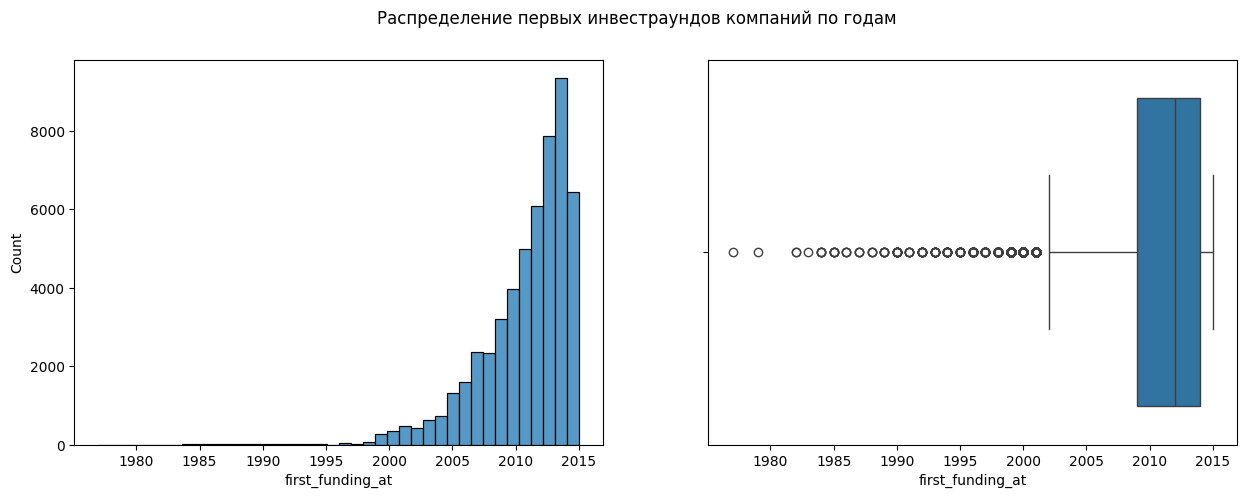

In [348]:
num_stat_and_graph(data_train, 'first_funding_at', 40, 'Распределение первых инвестраундов компаний по годам')

Как видно из таблицы и графика выше года в которые проводились певые инвестраунды компаний, распределены от 1977 до 2015 года. В целом проглядывается значений распределения от года в году, однако в  2015 году компаний поучавствоваших в первыом для себя инвестраунде, оказалось ощутимо меньше, чем в 2013 и 2014 годах. Далее изучим распределение параметра 'last_funding_at':

count   52516.0
mean     2012.0
std         3.3
min      1977.0
25%      2011.0
50%      2013.0
75%      2014.0
max      2015.0
Name: last_funding_at, dtype: float64

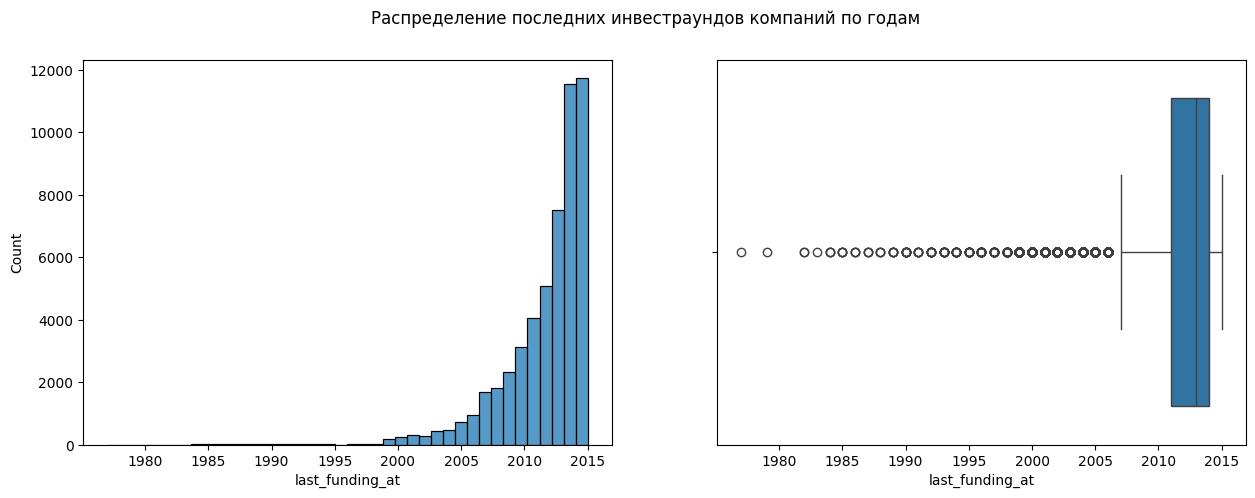

In [349]:
num_stat_and_graph(data_train, 'last_funding_at', 40, 'Распределение последних инвестраундов компаний по годам')

Как видно из таблицы и графика выше года в которые проводились последние инвестраунды компаний, распределены от 1977 до 2015 года. В целом проглядывается увеличение значений распределения от года в году, при этом увеличение количества компаний поучавствоваших в последнем  для себя инвестраунде, особенно заметно в 2013 году, относительно 2012 года и в 2014 году, относительно 2014 года. Увеличение количества компаний в 2015 году относительно 2014 года - несущественно. Далее изучим распределение параметра 'lifetime':

count   52516.0
mean     3140.8
std      2147.8
min        19.0
25%      1739.0
50%      2557.0
75%      4018.0
max     17378.0
Name: lifetime, dtype: float64

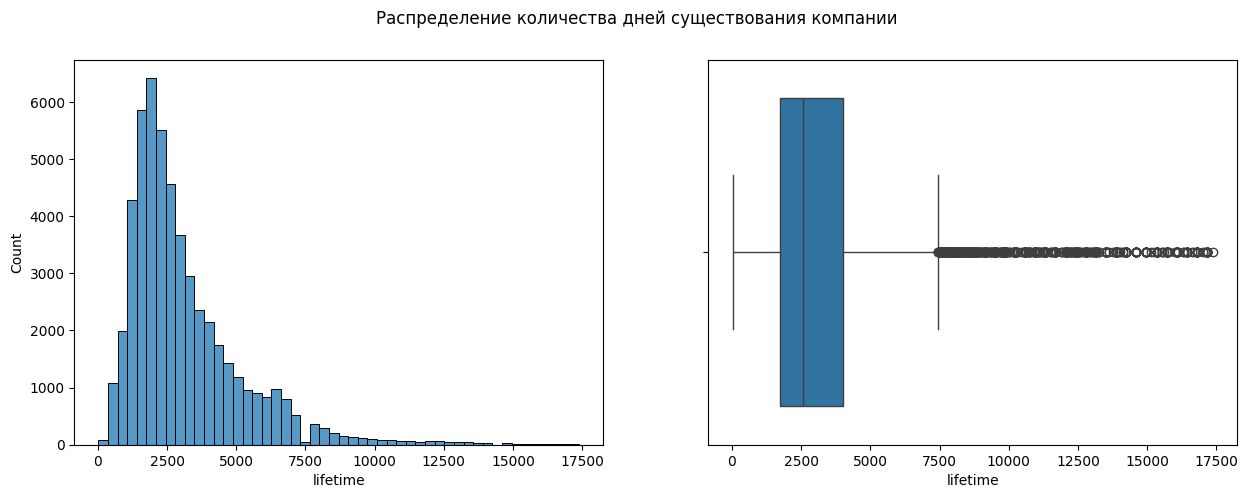

In [350]:
num_stat_and_graph(data_train, 'lifetime', 50, 'Распределение количества дней существования компании')

Как видно из графика выше, распределение параметра имеет смещение влево с длинным правым "хвостом". Однако максимальное значение параметра в 17378 день (47,6 лет) реально, соотвтетсвенно оснований для удаления каких-либо значений данного параматера у нас не имеется. Рассмотрим распределение количественных параметров в тестовом датасете, начнем с параметра 'funding_total_usd':

count        13125.0
mean      13691381.8
std       82827369.2
min              1.0
25%         501000.0
50%        2000000.0
75%        6513865.0
max     4715000000.0
Name: funding_total_usd, dtype: float64

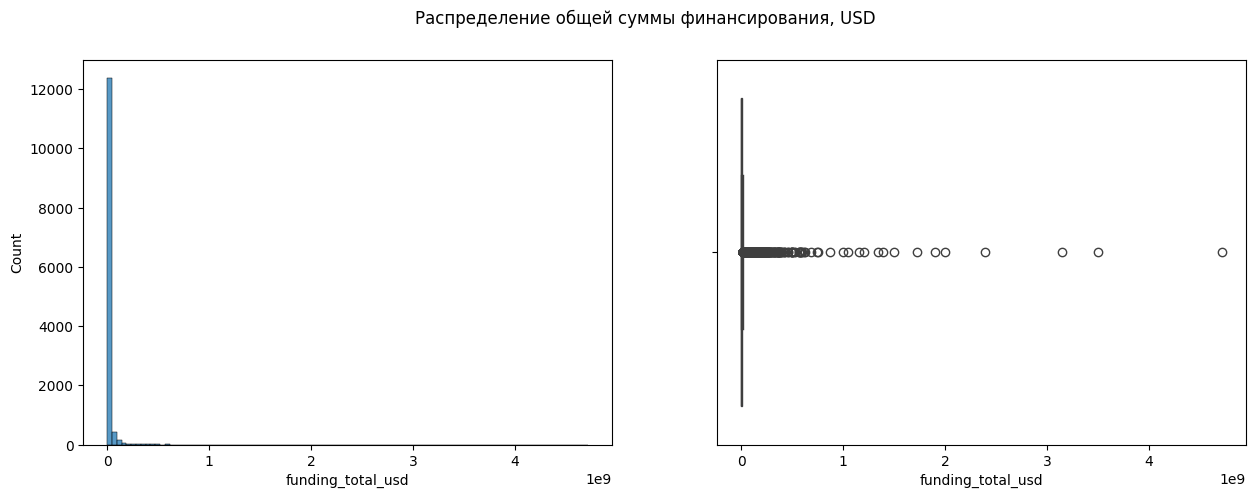

In [351]:
num_stat_and_graph(data_test, 'funding_total_usd', 100, 'Распределение общей суммы финансирования, USD')

Как видно из таблицы выше, значения параметра 'funding_total_usd' имеют весьма значительный  размах значений от 0 до 4_715_00_000, ввиду чего, графики выше смотрятся неиформативными. Для лучшего понимания распределения параметра, рассмотрим гистограмму на различных диапазонах его значений:

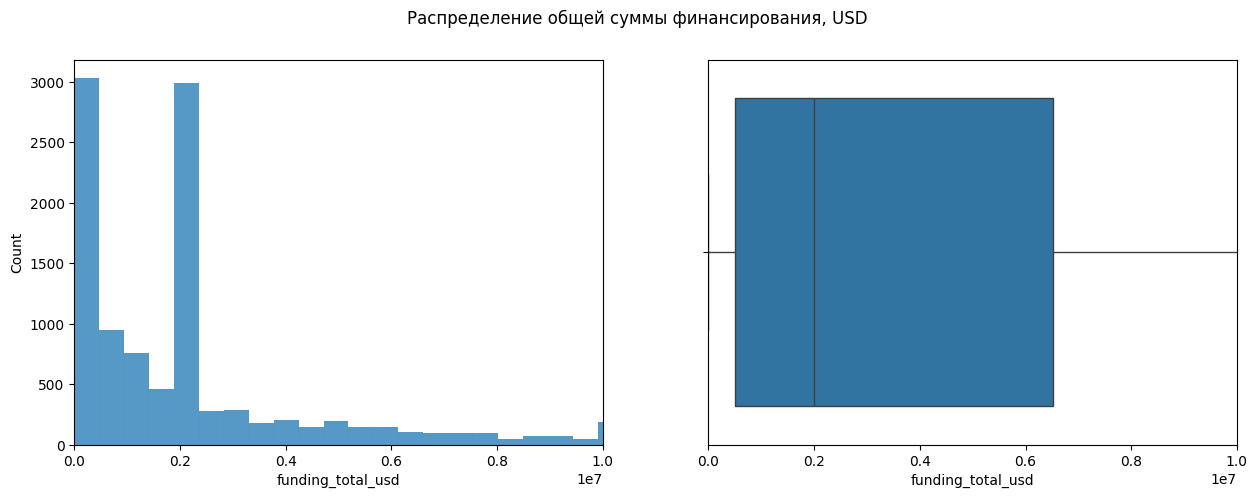

In [352]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
sns.histplot(data_test['funding_total_usd'], bins=10000, ax = axes[0])
axes[0].set_xlim(0,10_000_000)
sns.boxplot(data=data_test, x= 'funding_total_usd')
axes[1].set_xlim(0,10_000_000)
fig.suptitle('Распределение общей суммы финансирования, USD');

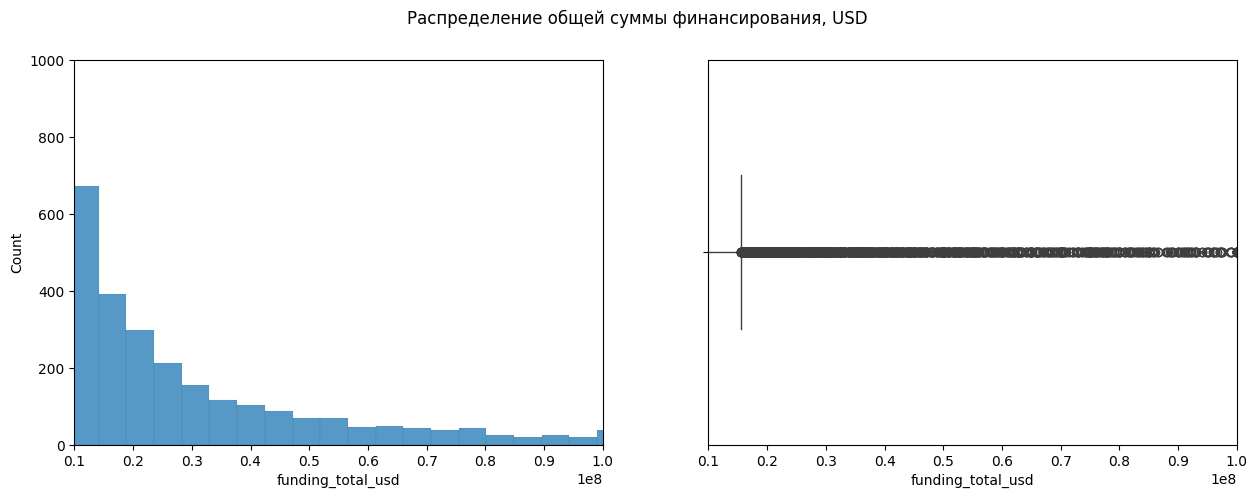

In [353]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
sns.histplot(data_test['funding_total_usd'], bins=1000, ax = axes[0])
axes[0].set_xlim(10_000_000,100_000_000)
axes[0].set_ylim(0,1000)
sns.boxplot(data=data_test, x= 'funding_total_usd')
axes[1].set_xlim(10_000_000,100_000_000)
fig.suptitle('Распределение общей суммы финансирования, USD');

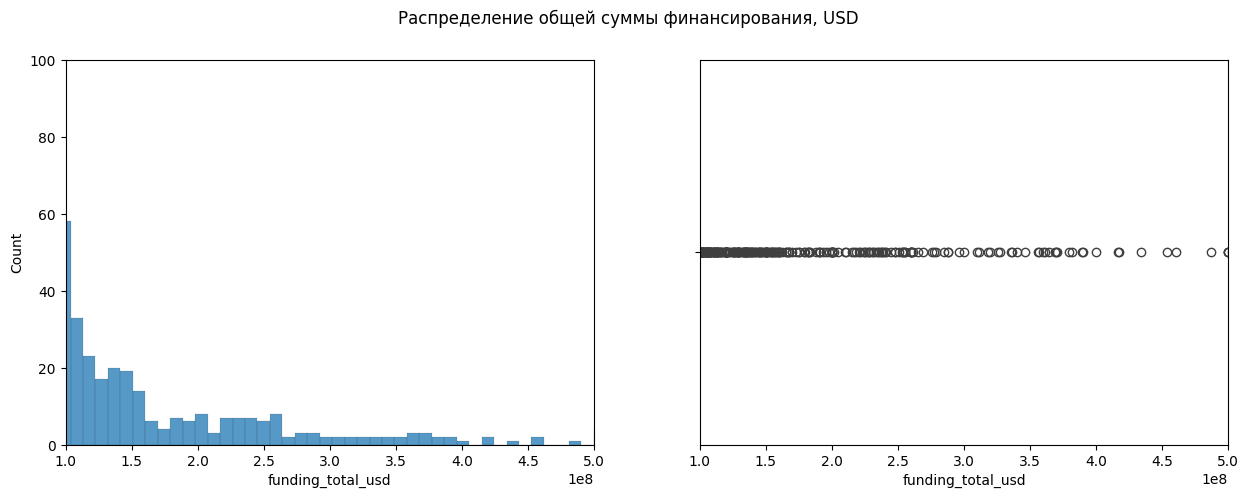

In [354]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
sns.histplot(data_test['funding_total_usd'], bins=500, ax = axes[0])
axes[0].set_xlim(100_000_000,500_000_000)
axes[0].set_ylim(0,100)
sns.boxplot(data=data_test, x= 'funding_total_usd')
axes[1].set_xlim(100_000_000,500_000_000)
fig.suptitle('Распределение общей суммы финансирования, USD');

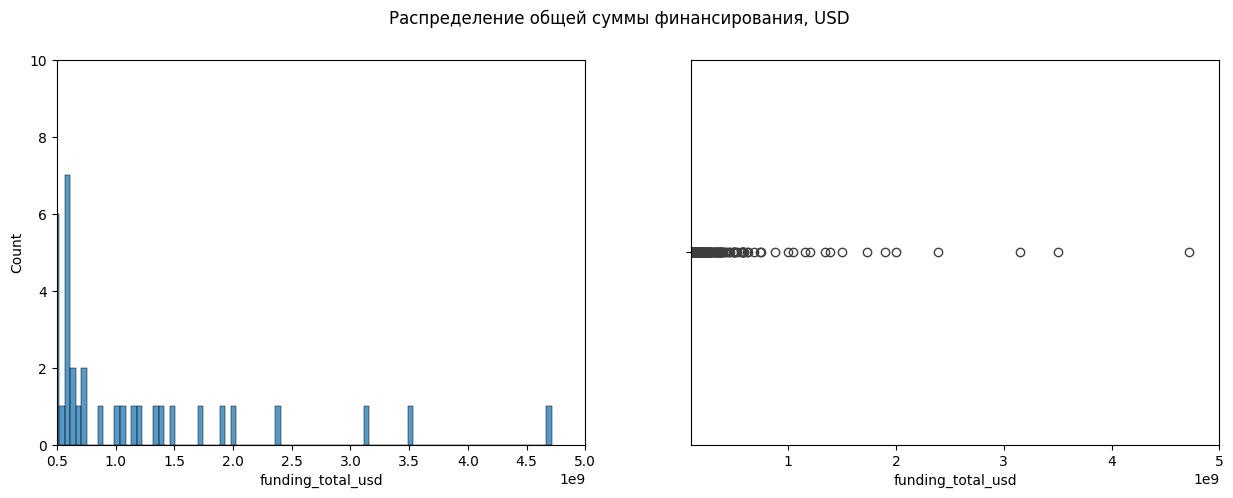

In [355]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
sns.histplot(data_test['funding_total_usd'], bins=100, ax = axes[0])
axes[0].set_xlim(500_000_000,5_000_000_000)
axes[0].set_ylim(0,10)
sns.boxplot(data=data_test, x= 'funding_total_usd')
axes[1].set_xlim(100_000_000,5_000_000_000)
fig.suptitle('Распределение общей суммы финансирования, USD');

Вцелом распределение параметра 'funding_total_usd' похоже на аналогичное распределение в тренировочном сете. Удалять какие либо выбросы из тестового датасеты мы не можем, т.к. это приведет к сокращению размерности датафрейма, что запрщено заданием. Изучим распределение параметра 'funding_round':

count   13125.0
mean        1.7
std         1.3
min         1.0
25%         1.0
50%         1.0
75%         2.0
max        15.0
Name: funding_rounds, dtype: float64

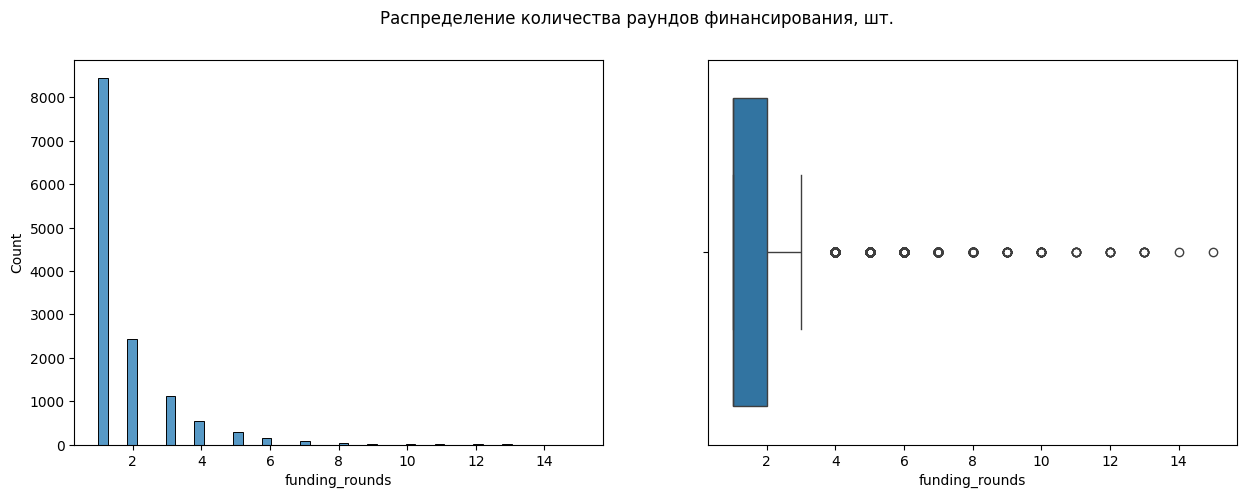

In [356]:
num_stat_and_graph(data_test, 'funding_rounds', 50, 'Распределение количества раундов финансирования, шт.')

Несмотря на тот факт, что "ящик с усами" считает все значения более 3-х - выбросами, нет оснований для удаления этих значений, т.к. данные цифры - реальны. Для проверки данной гипотезы выведем топ-20 самых "молодых" компаний (с момента первого раунда финансирования), поучавствующих более чем в 3-х инвестраундах.

In [357]:
data_test[data_test['funding_rounds'] > 3].sort_values('first_funding_at', ascending=False).head(20)

name            category_list  funding_total_usd  \
8172                   Sponsoo              Advertising           141403.6   
148                   TalentIQ                Analytics           575000.0   
7066                    Eyewiz                   Hotels           141800.0   
11763             BrightLocker     E-Commerce Platforms          2055000.0   
9051                  Conkwest            Biotechnology        142004397.0   
1422                  Newsreps            Digital Media           170000.0   
4351    Mobiquity Technologies                 Software         23888600.0   
5069                      Jibo  Artificial Intelligence         38600000.0   
8154   Supreme Pharmaceuticals          Pharmaceuticals          2004551.0   
9175         LiftForward, Inc.       Financial Services        261300000.0   
10947              ArgonCredit               Algorithms         80050000.0   
5685                   Qufenqi                 Payments        225000000.0   
5933                  Tinitell       Internet of Things          2141000.0   
11081    DropWise Technologies       Advanced Materials           340000.0   
11968              CellBreaker   Information Technology           396000.0   
429               isaac10 GmbH               Accounting           595504.0   
10382          PharmRight Corp                  Medical          3100000.0   
3692                   travayl            Online Travel           138000.0   
6307                     Rover         Local Businesses          1000000.0   
1811                     VICIS               Technology          6250000.0   

      country_code state_code         region           city  funding_rounds  \
8172           DEU          4        Hamburg        Hamburg               6   
148            USA         CA    SF Bay Area  San Francisco               4   
7066           USA         NC      Charlotte      Charlotte               6   
11763          USA         TX         Austin          Other               5   
9051           USA         CA     CA - Other          Other               4   
1422         Other      Other          Other          Other               4   
4351           USA         NY    Long Island          Other               4   
5069           USA         MA         Boston      Cambridge               5   
8154           CAN         BC      Vancouver      Vancouver               4   
9175           USA         NY  New York City       New York               4   
10947          USA         IL        Chicago        Chicago               4   
5685           CHN         22        Beijing        Beijing               4   
5933         Other      Other      Stockholm      Stockholm               4   
11081          USA         MA         Boston      Cambridge               4   
11968      unknown    unknown        unknown        unknown               4   
429            DEU      Other          Other          Other               4   
10382          USA      Other          Other     Charleston               4   
3692         Other         12          Other           Oslo               4   
6307           CAN         ON        Toronto        Toronto               4   
1811           USA         WA        Seattle        Seattle               4   

       first_funding_at  last_funding_at  lifetime  
8172               2015             2015      1253  
148                2015             2015      1096  
7066               2014             2015      1290  
11763              2014             2015      1375  
9051               2014             2015      1912  
1422               2014             2015      1531  
4351               2014             2015      7305  
5069               2014             2015      2192  
8154               2014             2015      1461  
9175               2014             2015      1583  
10947              2014             2015      1492  
5685               2014             2015      1402  
5933               2014             20

SponsooКак видно из таблицы выше, компания Sponsoo (индекс 8172) провела свой первый инвестраунд в 2015 году, при этом за этот срок она поучавствовала в 6-ти инвестраундах, т.е. приблизительно один раунд в полгода, что выглядит реальным. Также выведем топ-20 компаний поучавствовавших в максимальном количестве инвестраундов:

In [358]:
data_test[data_test['funding_rounds'] > 3].sort_values('funding_rounds', ascending=False).head(20)

name              category_list  \
6568                 Aperto Networks                     Mobile   
11392                          Aviir              Biotechnology   
12911            VeriTeQ Corporation                     Mobile   
12954    Health Enhancement Products        Health and Wellness   
3449         GlassHouse Technologies            Cloud Computing   
6210                Avaxia Biologics              Biotechnology   
11399           Lithium Technologies                      Other   
2953                           Carma  Collaborative Consumption   
4677                   Delivery Hero                   Delivery   
12726                    TRIA Beauty                 E-Commerce   
7036                  Delivery Agent                 E-Commerce   
664                        FreeAgent                   Software   
7077                         Sitrion              Collaboration   
10512                       Flipkart                 E-Commerce   
4052     Mode Media (fka Glam Media)           Content Creators   
4634   Advanced Inquiry Systems Inc.             Semiconductors   
11069      TeleCommunication Systems                     Mobile   
11689                    Net Element                 E-Commerce   
2521                             Fab                       Apps   
7008                       Satmetrix           Loyalty Programs   

       funding_total_usd country_code state_code            region  \
6568         160279779.0          USA         CA       SF Bay Area   
11392         70930000.0          USA         CA           Anaheim   
12911         22058331.0          USA         FL      Palm Beaches   
12954          5429628.0          USA         MI           Detroit   
3449         155710155.0          USA         MA            Boston   
6210          27517913.0          USA         MA            Boston   
11399        151650012.0          USA         CA       SF Bay Area   
2953          10100000.0        Other          4             Other   
4677        1390267370.0      unknown    unknown           unknown   
12726        277226267.0          USA         CA       SF Bay Area   
7036         138442109.0          USA         CA       SF Bay Area   
664           12113690.0          GBR      Other             Other   
7077          59838411.0      unknown    unknown           unknown   
10512       3151140000.0          IND         19         Bangalore   
4052         244600000.0          USA         CA       SF Bay Area   
4634          36519878.0          USA      Other  Portland, Oregon   
11069        150450000.0          USA         MD         Baltimore   
11689        156400000.0          USA         FL             Miami   
2521         336325000.0          USA         NY     New York City   
7008          50800000.0          USA         CA       SF Bay Area   

                city  funding_rounds  first_funding_at  last_funding_at  \
6568        Milpitas              15              1999             2010   
11392         Irvine              14              2006             2013   
12911          Other              13              2009             2015   
12954          Other              13              2009             2014   
3449      Framingham              13              2001             2012   
6210       Lexington              13              2011             2015   
11399  San Francisco              13              2007             2013   
2953            Cork              13              2007             2015   
4677         unknown              12              2010             2015   
12726     Pleasanton              12              2007             2014   
7036   San Francisco              12              2005             2014   
664        Edinburgh              12              2009             2015   
7077         unknown              12              2004             2014   
10512      Bangalore              12              2009             2015   
4052        Brisbane        

Как видно из таблицы выше, среди выведенных компаний нет компаний, имеющих неадекватно небольшой интервал с момента первого раунда финансированя, относительно общего количества раундов. Рассмотрим распределение параметра 'lifetime':

count   13125.0
mean     3097.6
std      2128.4
min        52.0
25%      1726.0
50%      2526.0
75%      3866.0
max     17167.0
Name: lifetime, dtype: float64

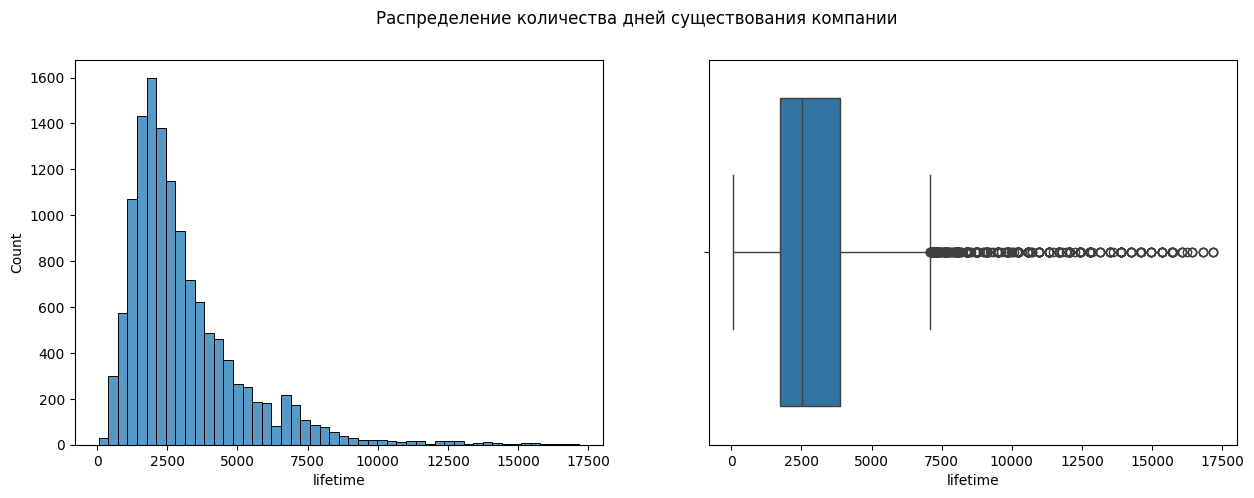

In [359]:
num_stat_and_graph(data_test, 'lifetime', 50, 'Распределение количества дней существования компании')

Как видно из графика выше, распределение параметра имеет смещение влево с длинным правым "хвостом". Однако максимальное значение параметра в 17167 день (47,0 лет) реально, соотвтетсвенно оснований для удаления каких-либо значений данного параматера у нас не имеется.

По результатам анализа распределений количественных параметров в тренировочной и тестовой выборке, можно прийти к выводу, что существенных отлтчий между распределениями данных параметров в представленных датасетах не наблюдается.

Рассмотрим  распределение категориальных параметров тренировочного датасета, начнем с параметра 'category_list'

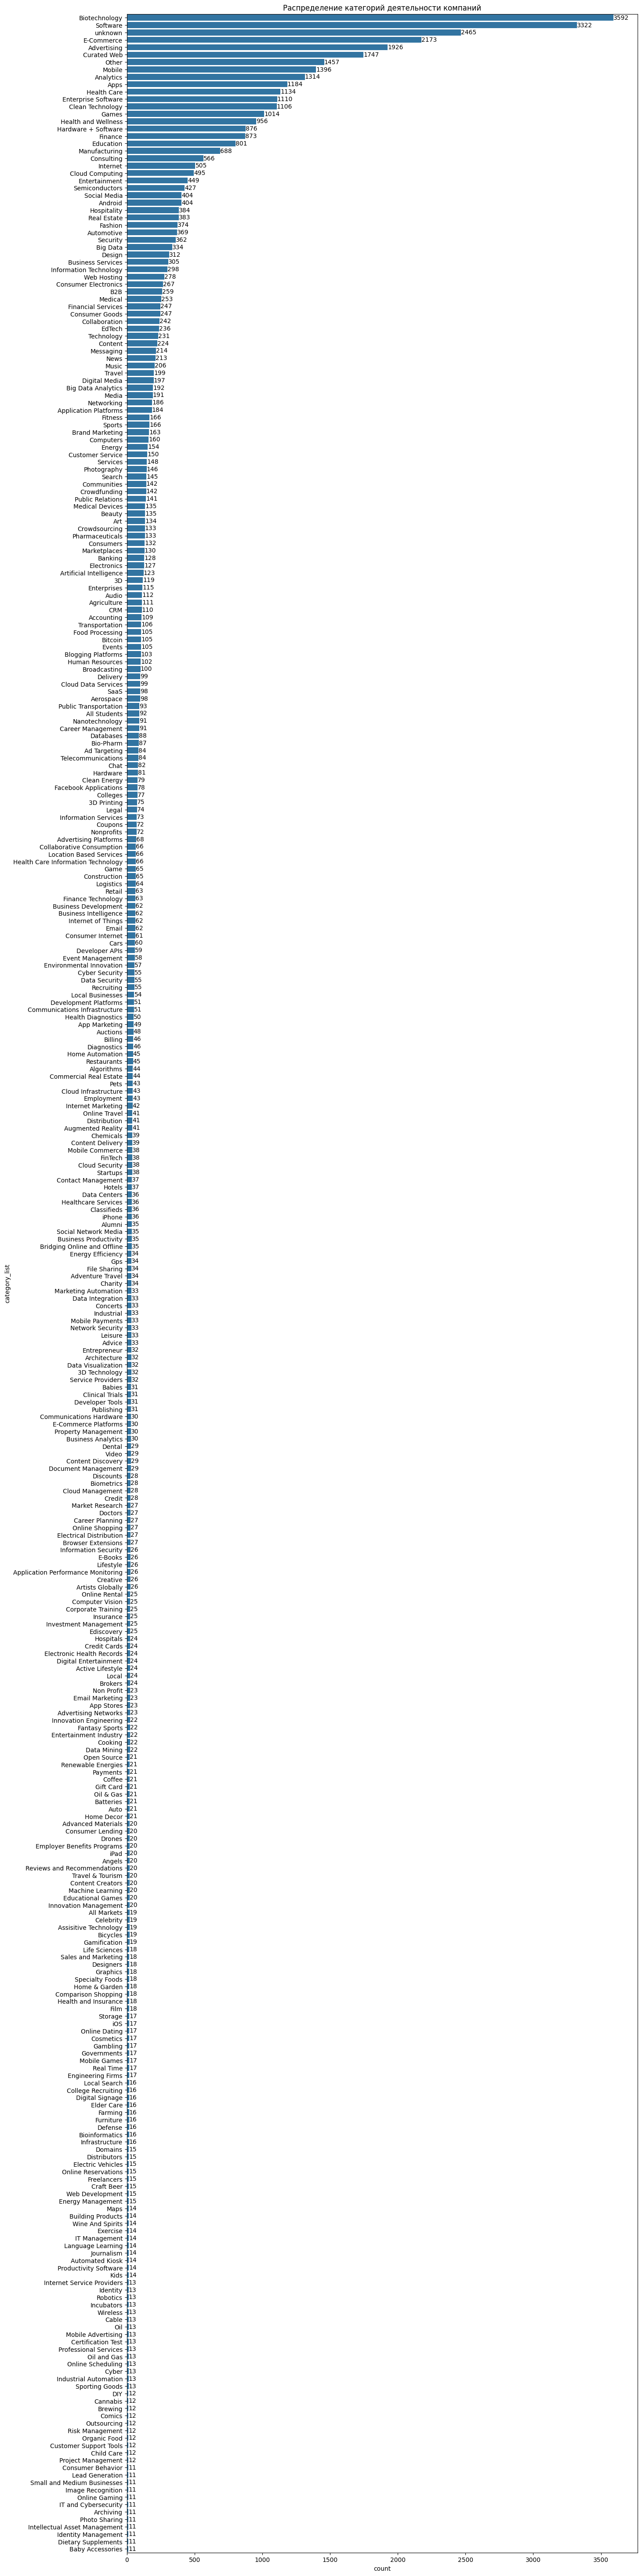

In [360]:
count_graph(
    data_train, 'category_list',
    'Распределение категорий деятельности компаний',
    15, 75
)

Обратим внимание, что категория 'unknown' занимает 3-е место по частоте встречаемости. Изучим распределение параметра 'status':

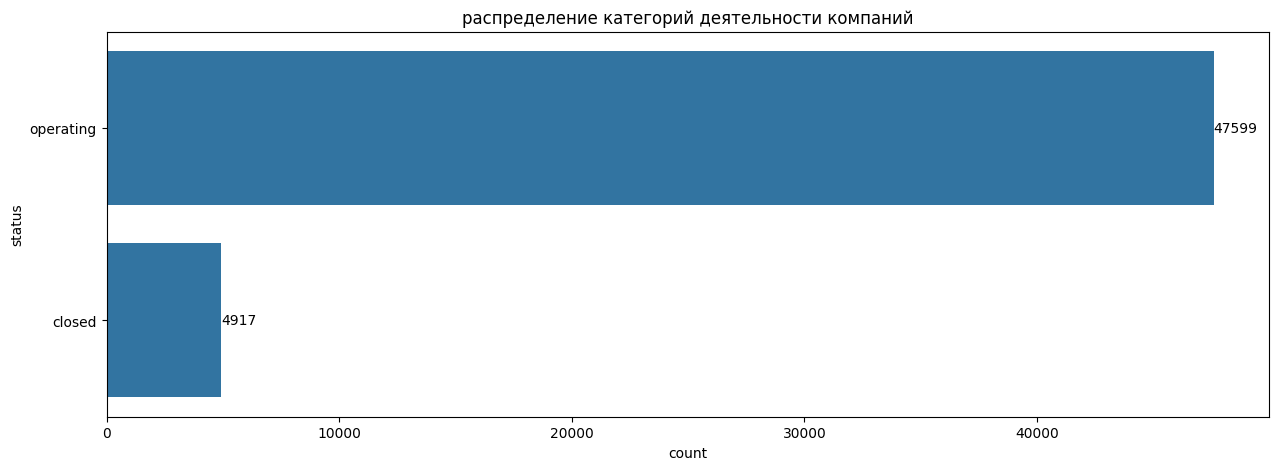

In [361]:
count_graph(
    data_train, 'status',
    'распределение категорий деятельности компаний',
    15, 5
)

In [362]:
len(data_train[data_train['status'] == 'closed']) / len(data_train) * 100

9.362860842409933

Как видно из графика и расчета выше, целевой признак имеет дисбаланс в тренировочном датасете, значение 'closed' прсивоено только 9,36% датасета. Рассмотрим распределение параметра 'country_code':

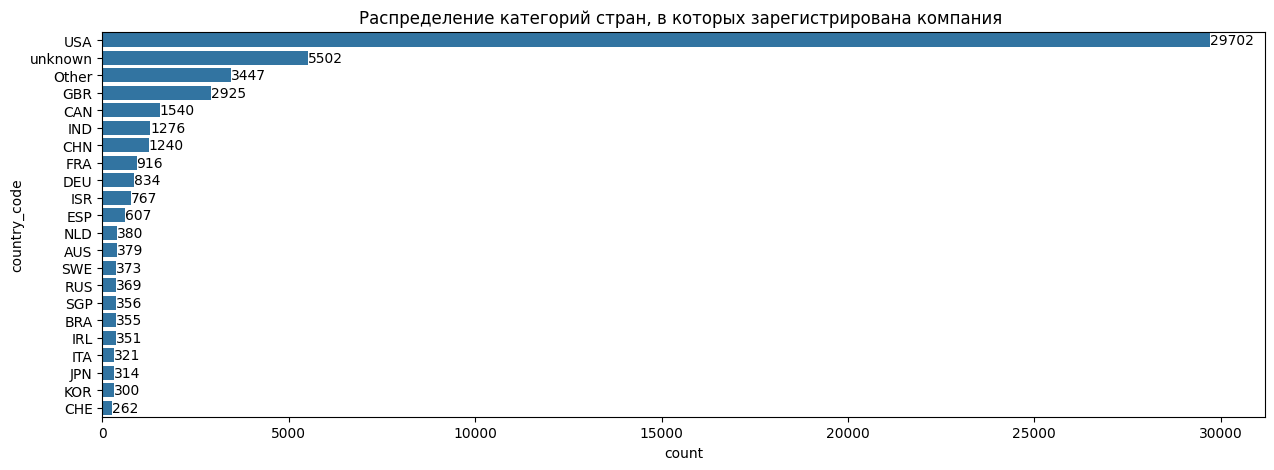

In [363]:
count_graph(
    data_train, 'country_code',
    'Распределение категорий стран, в которых зарегистрирована компания ',
    15, 5
)

Как видно из графика выше, категория 'unknown' заняла второе, а категория 'Other третье место, в списке стран, в которых зарегистрированы компании. Рассмотрим распределение параметра 'state_code':

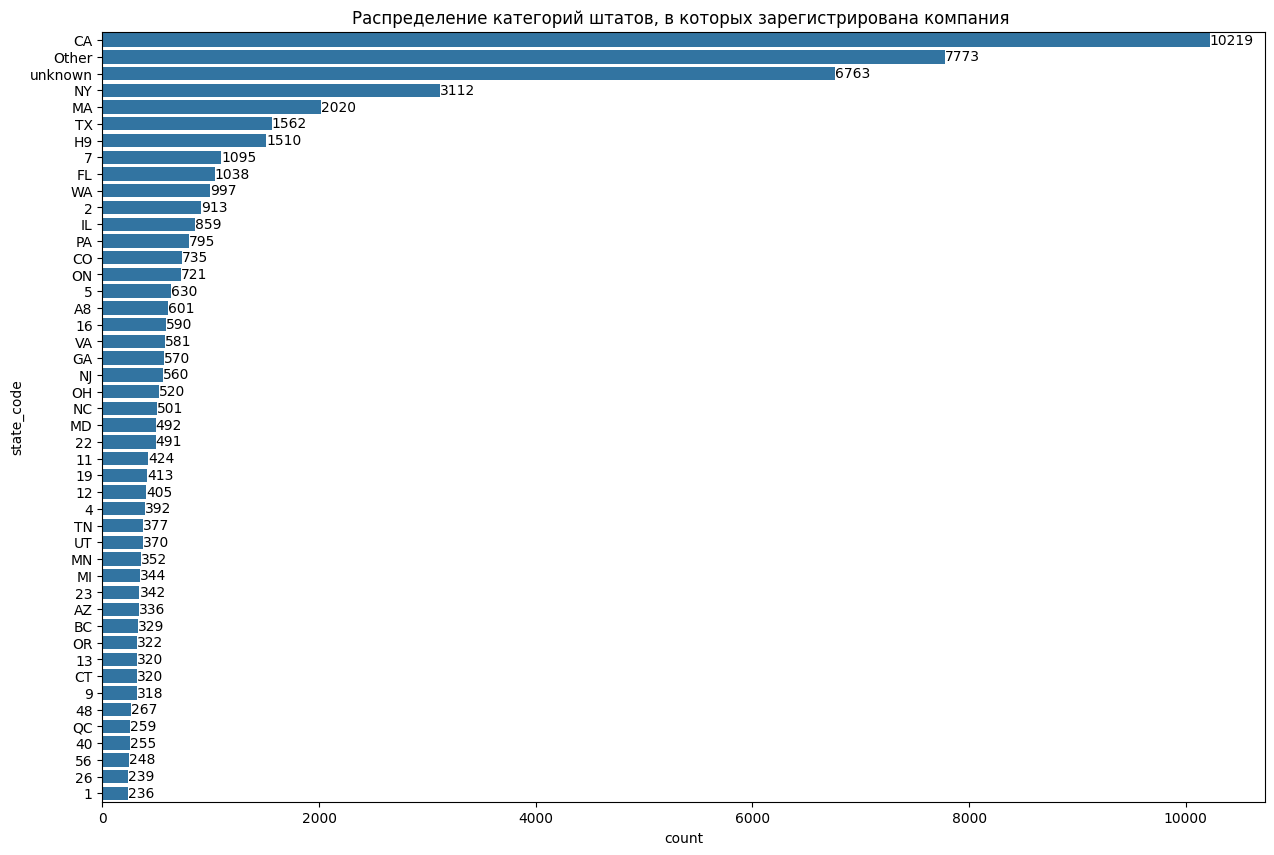

In [364]:
count_graph(
    data_train, 'state_code',
    'Распределение категорий штатов, в которых зарегистрирована компания ',
    15, 10
)

Как видно из графика выше, категория 'Other' заняла второе, а категория 'unknown' третье место, в списке штатов, в которых зарегистрированы компании. Рассмотрим распределение параметра 'region'.

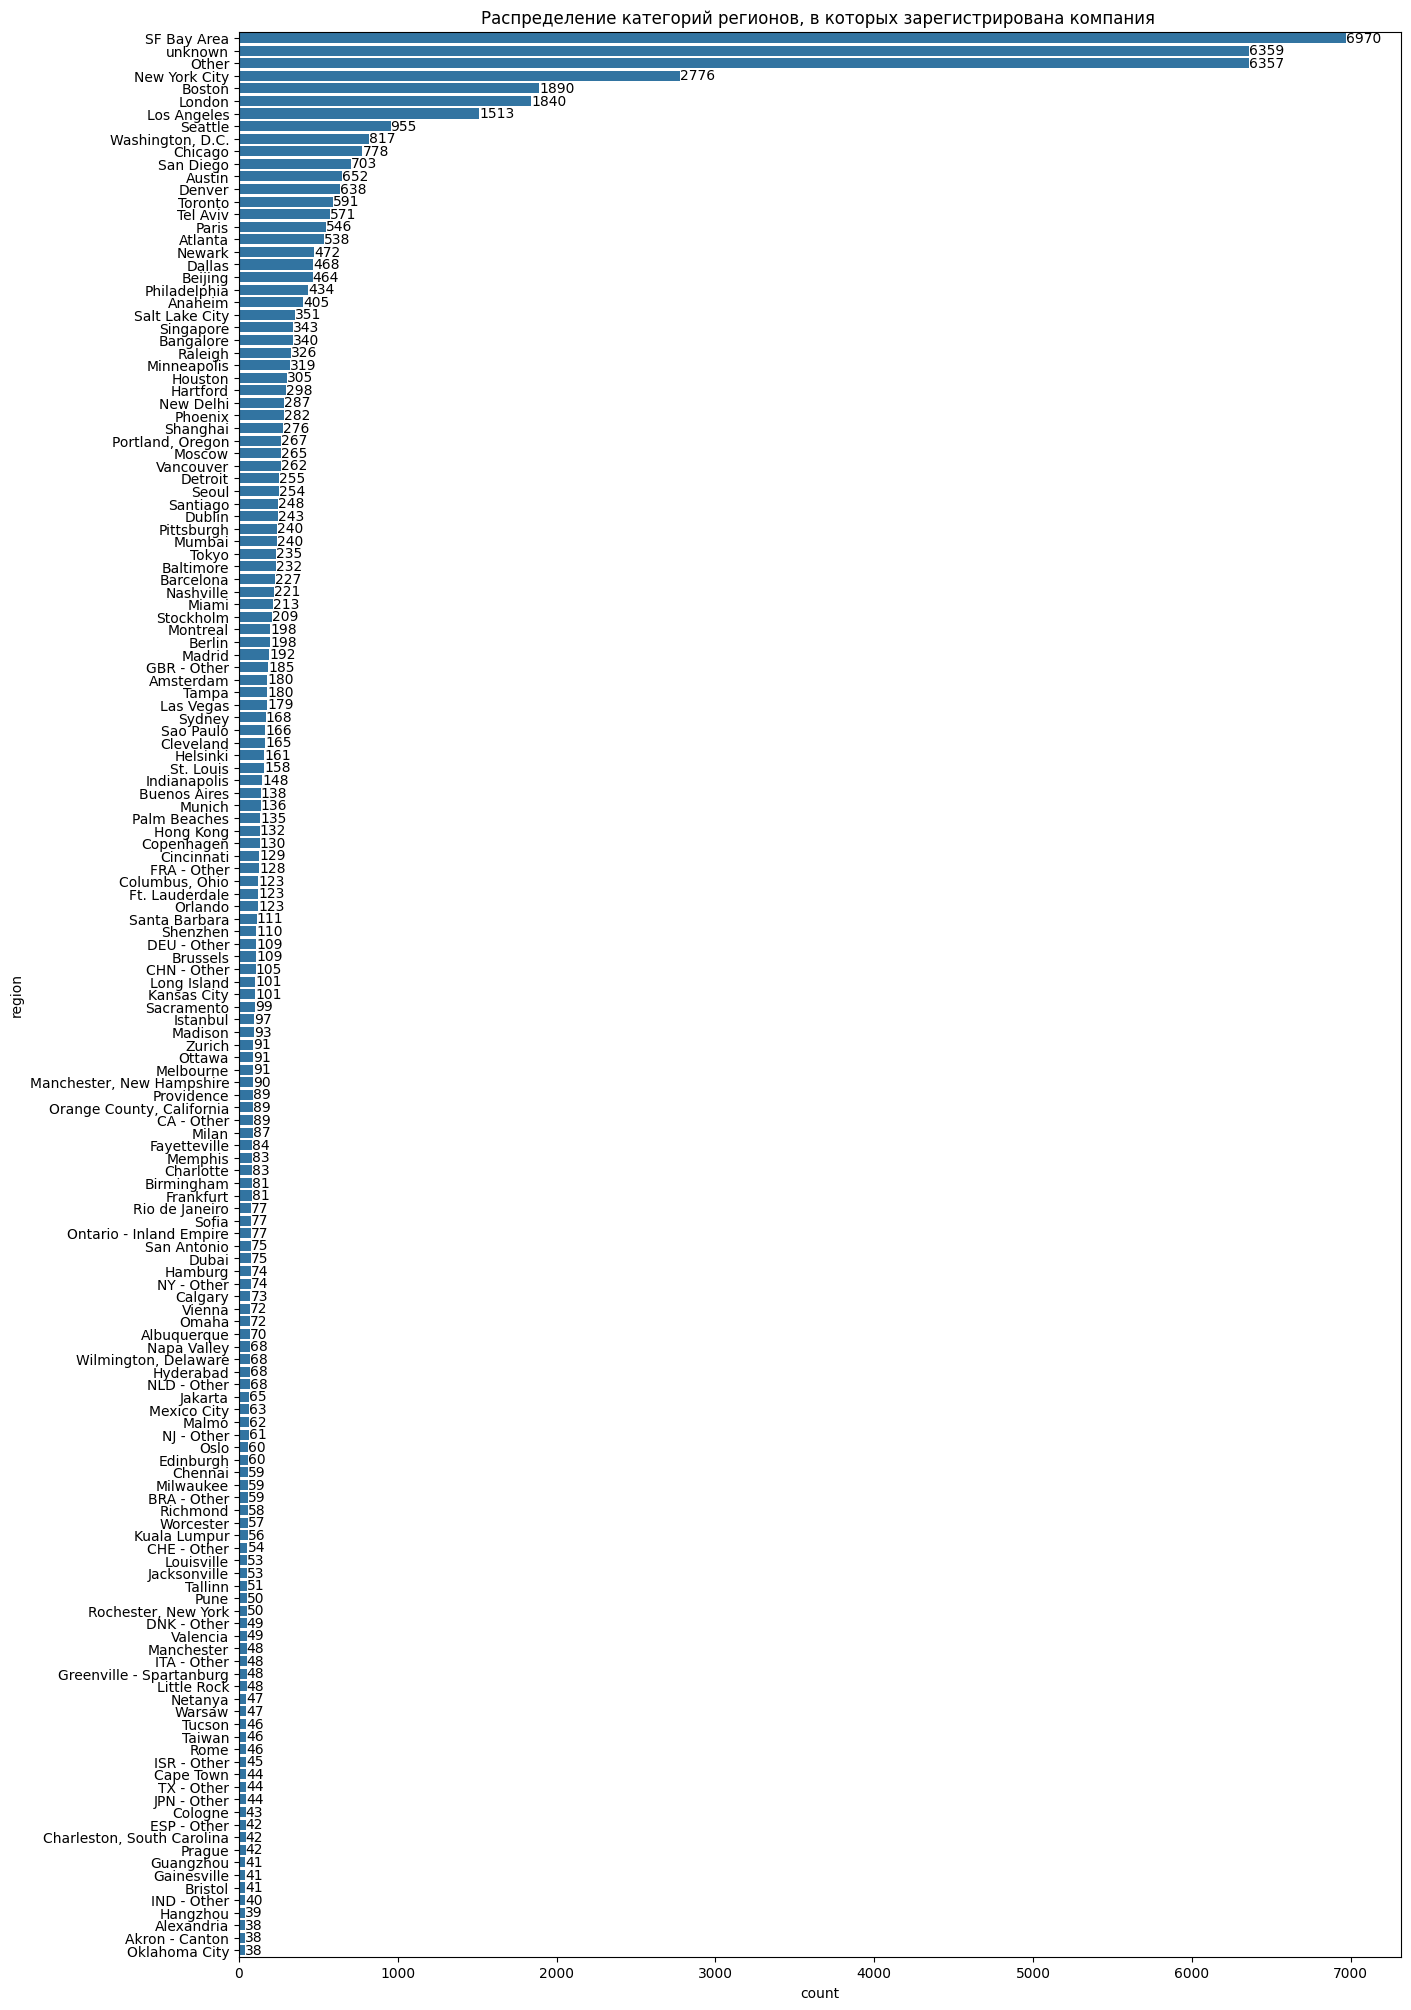

In [365]:
count_graph(
    data_train, 'region',
    'Распределение категорий регионов, в которых зарегистрирована компания ',
    15, 25
)

Как видно из графика выше, категория 'unknown' заняла второе, а категория 'Other третье место, в списке регионов, в которых зарегистрированы компании. Рассмотрим распределение параметра 'city.

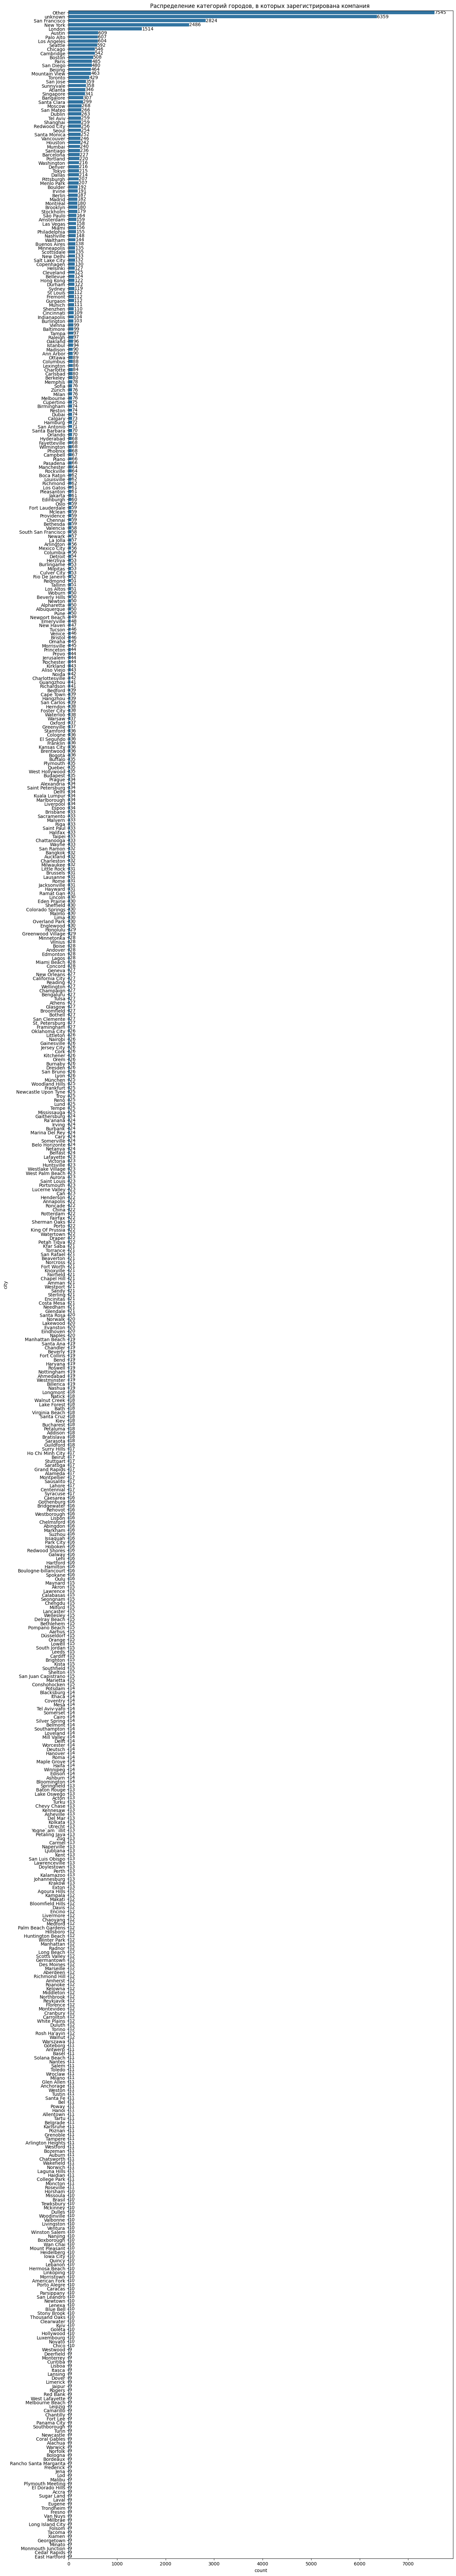

In [366]:
count_graph(
    data_train, 'city',
    'Распределение категорий городов, в которых зарегистрирована компания ',
    15, 100
)

Как видно из графика выше, категория 'Other' заняла первое, а категория 'unknown' второе место, в списке городов, в которых зарегистрированы компании. Рассмотрим  распределение категориальных параметров тестового датасета, начнем с параметра 'category_list'

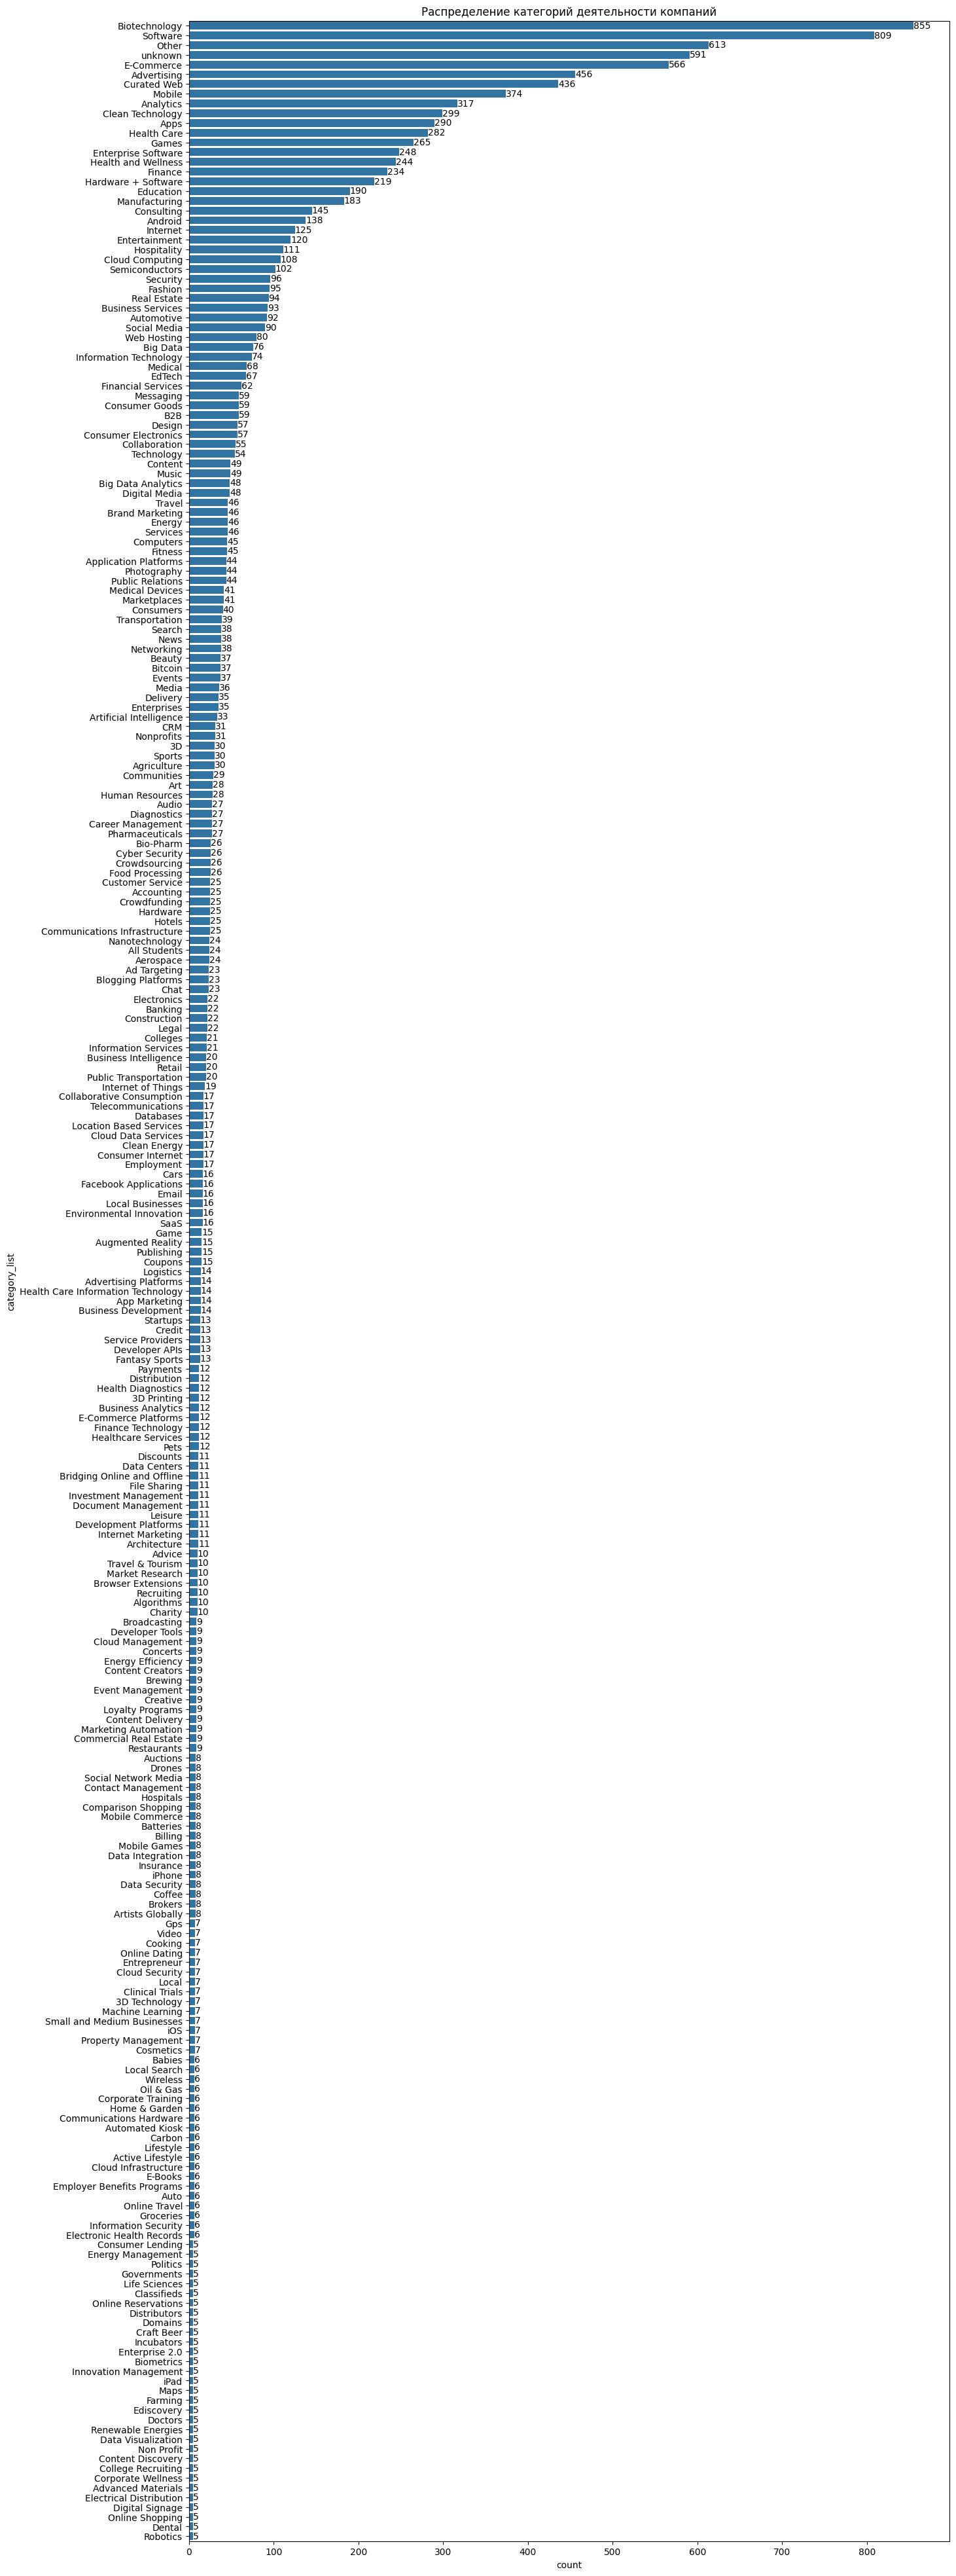

In [367]:
count_graph(
    data_test, 'category_list',
    'Распределение категорий деятельности компаний',
    15, 50
)

Как видно из графика выше, категория 'Other' заняла третье, а категория 'unknown' четвертое место, в списке категорий деятельности компаний. Изучим распределение параметра 'country_code':

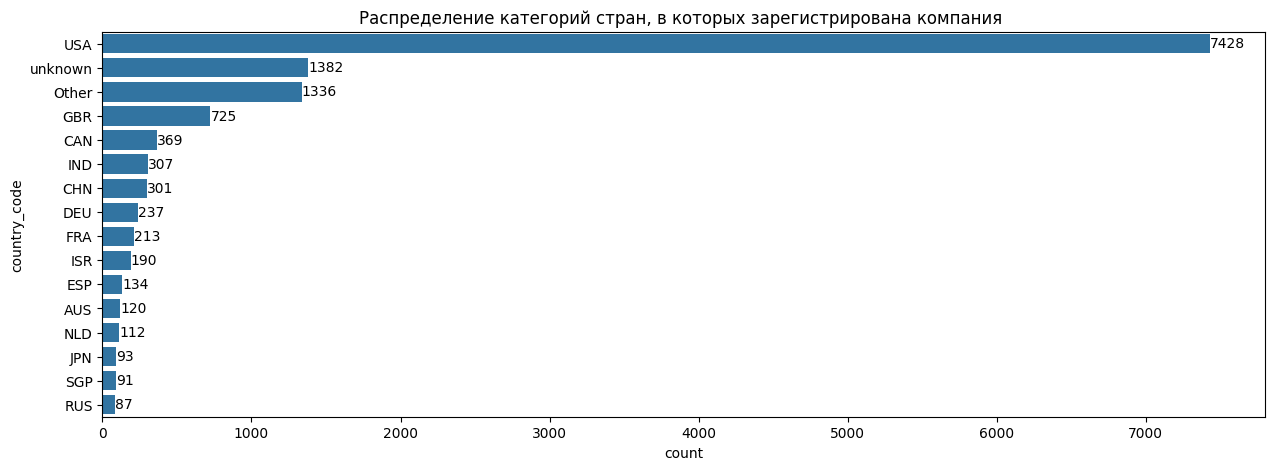

In [368]:
count_graph(
    data_test, 'country_code',
    'Распределение категорий стран, в которых зарегистрирована компания ',
    15, 5
)

Как видно из графика выше, категория 'unknown' заняла второе, а категория 'Other третье место, в списке стран, в которых зарегистрированы компании. Изучим распределение параметра 'state_code':

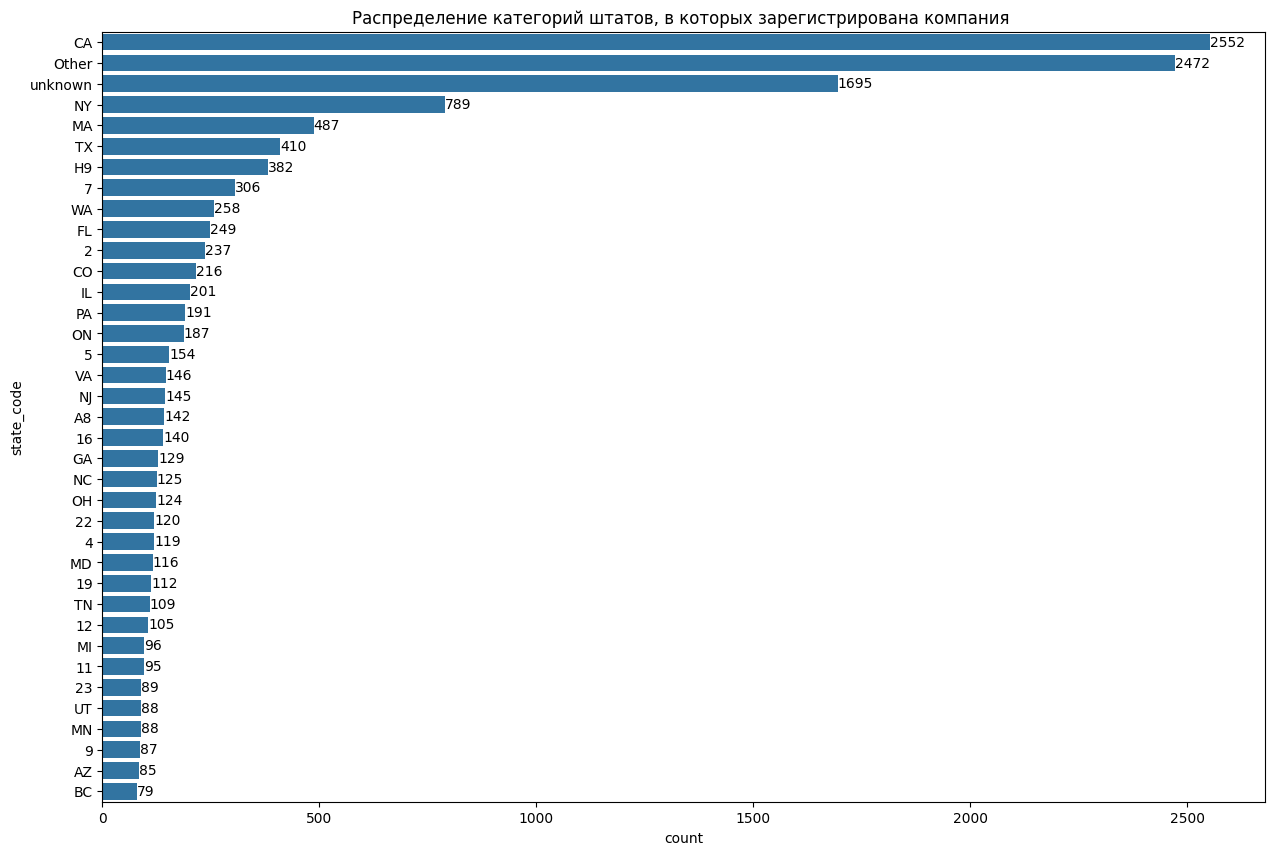

In [369]:
count_graph(
    data_test, 'state_code',
    'Распределение категорий штатов, в которых зарегистрирована компания ',
    15, 10
)

Как видно из графика выше, категория 'Other' заняла второе, а категория 'unknown'  третье место, в списке штатов, в которых зарегистрированы компании. Рассмотрим распределение параметра 'region'

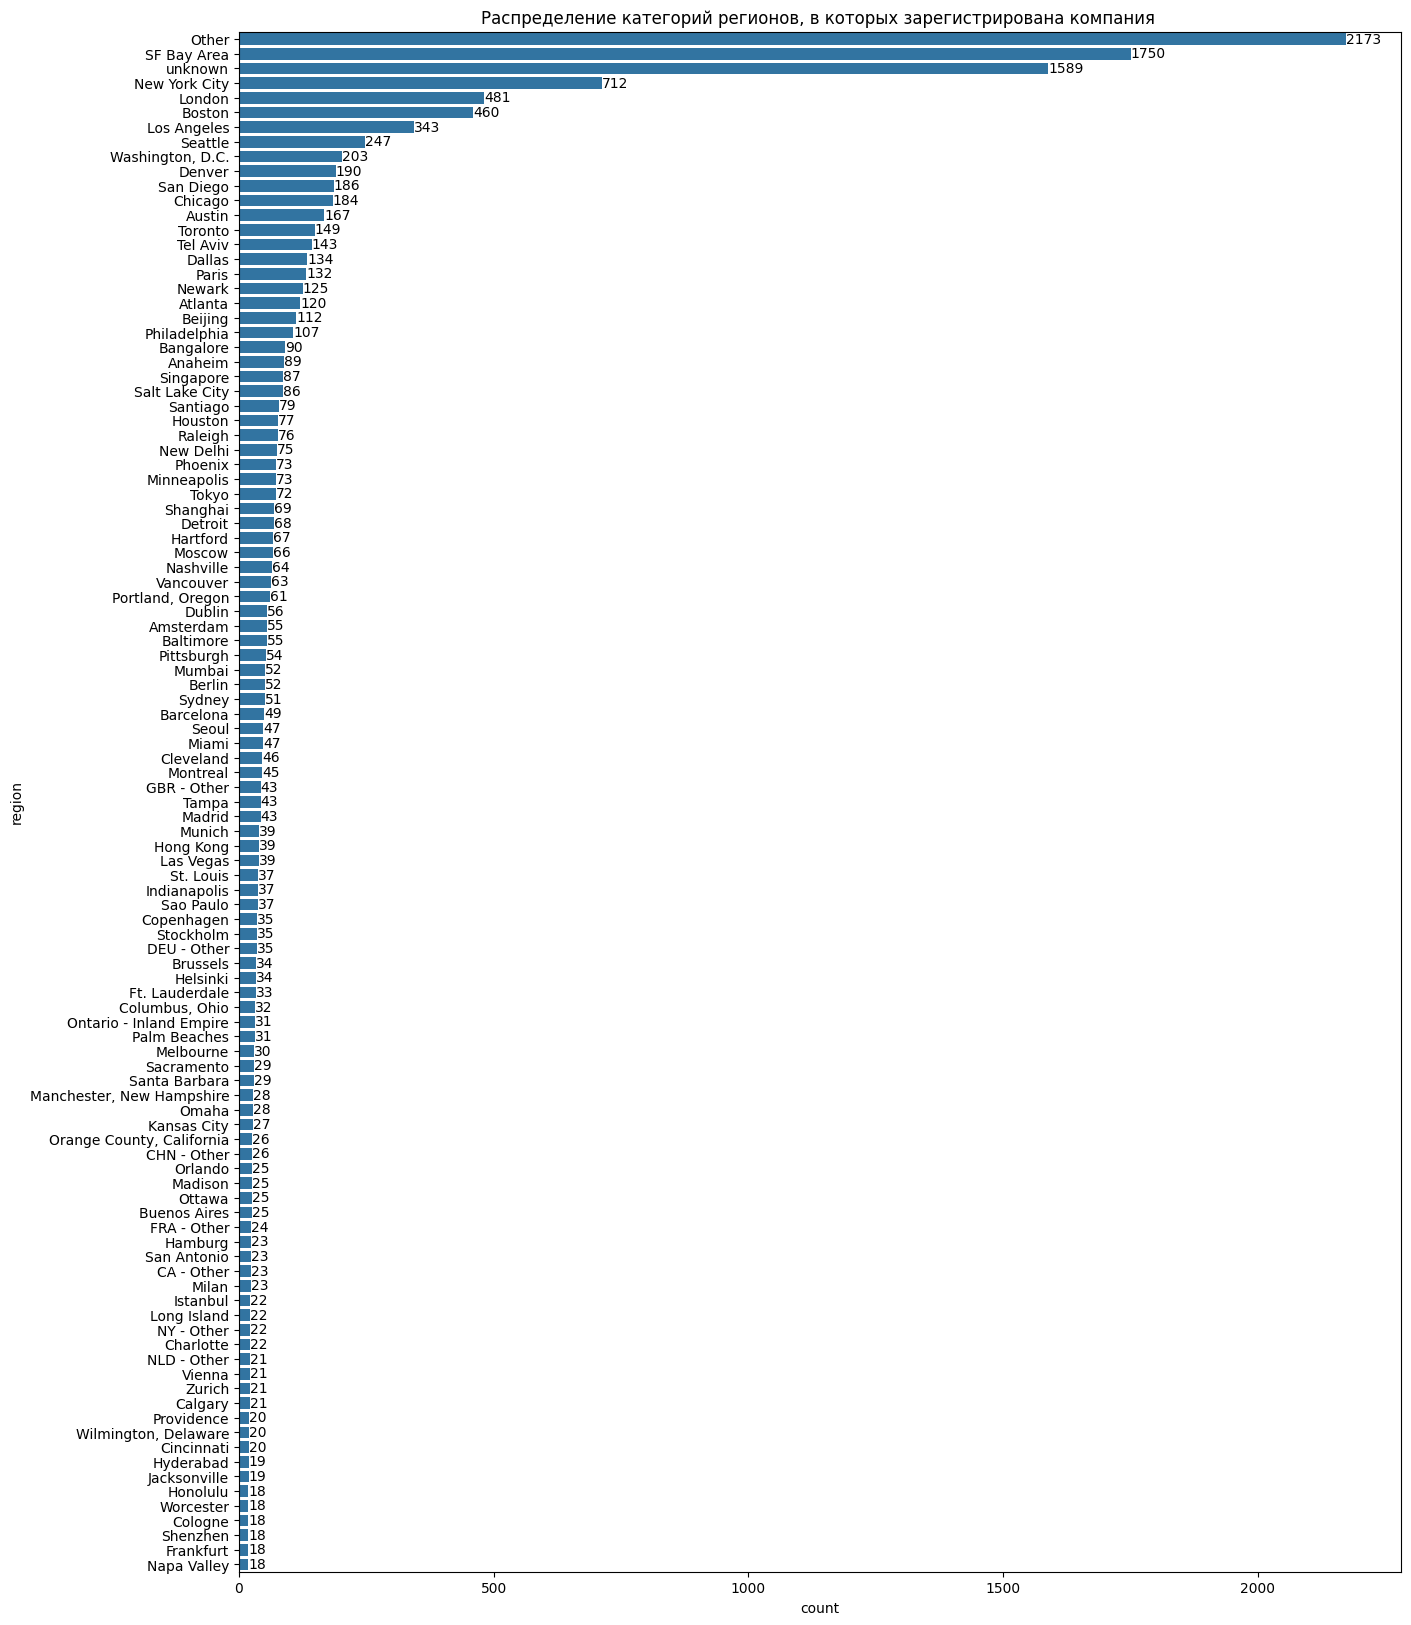

In [370]:
count_graph(
    data_test, 'region',
    'Распределение категорий регионов, в которых зарегистрирована компания ',
    15, 20
)

Как видно из графика выше, категория 'Other' заняла первое, а категория 'unknown'  третье место, в списке регионов, в которых зарегистрированы компании. Рассмотрим распределение параметра 'city.

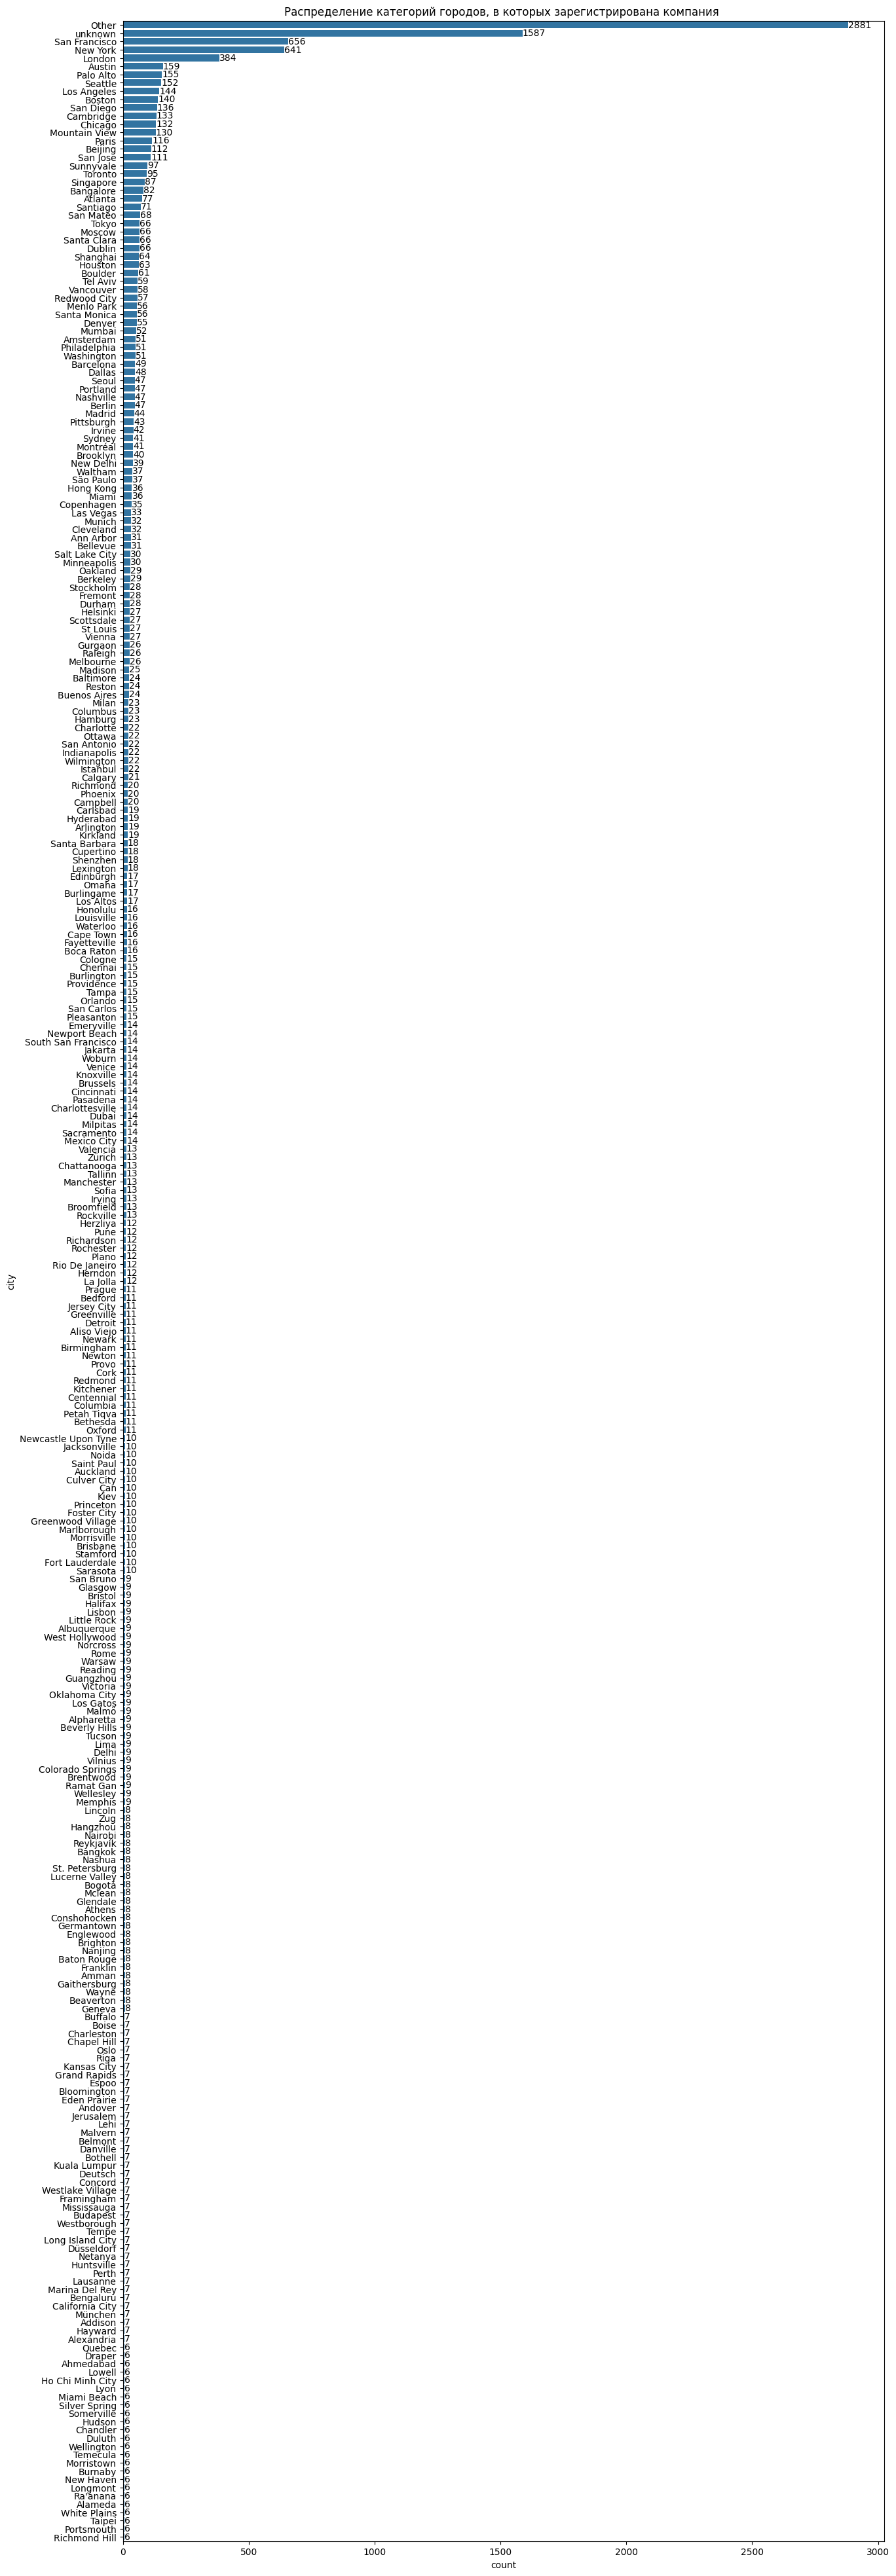

In [371]:
count_graph(
    data_test, 'city',
    'Распределение категорий городов, в которых зарегистрирована компания ',
    15, 50
)

Как видно из графика выше, категория 'Other' заняла первое, а категория 'unknown' второе место, в списке городов, в которых зарегистрированы компании. По результатам анализа распределений категориальных параметров в тренировочной и тестовой выборке, можно прийти к выводу, что существенных отлтчий между распределениями данных параметров в представленных датасетах не наблюдается. Однако из за заполнения пропуков категорией 'unknown' и сокращения категорий за счет присваивания значения 'Other' непопулярным категориям, данные значения вышли в топ-категорий по количеству. Рассмотрим рассеяние количественных признаков относительно времени существования стартапа в днях. В качестве таргета примем значения столбца 'status'. Для корректного рассмотрения параметра 'funding_total_usd', отсеем имеющиеся выбросы по данному параметру

In [372]:
data_train1 = data_train[data_train['funding_total_usd'] < 10_000_000]

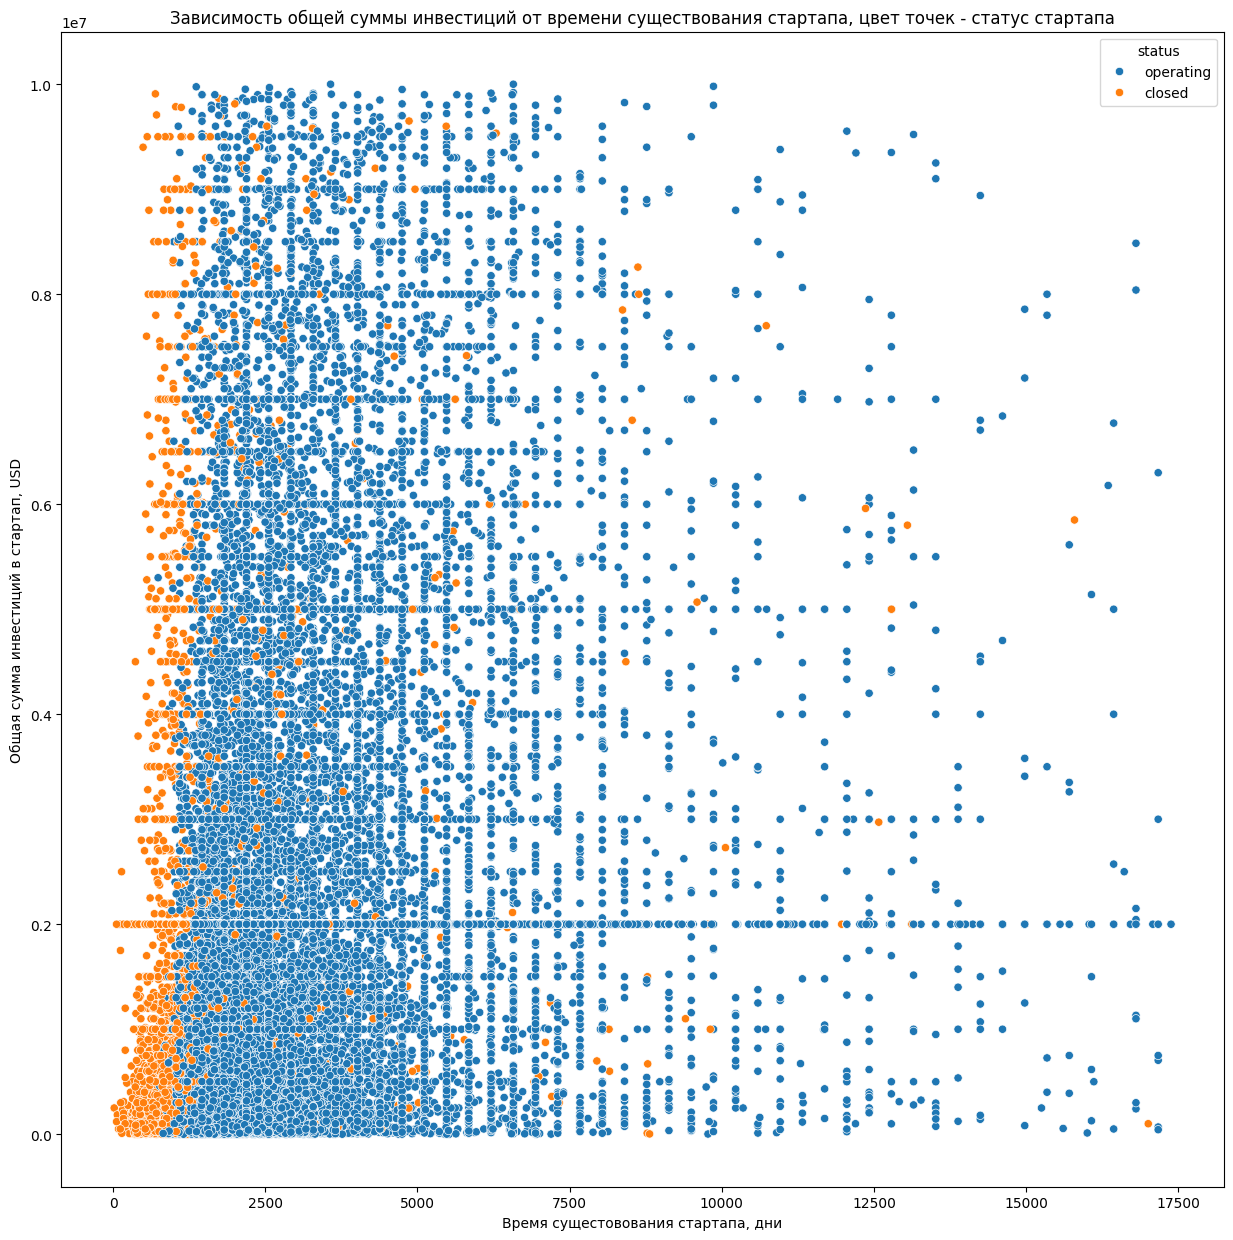

In [373]:
axes, fig = plt.subplots(figsize=(15,15))
sns.scatterplot(data=data_train1, x='lifetime', y='funding_total_usd', hue='status');
plt.xlabel('Время сущестовования стартапа, дни');
plt.ylabel('Общая сумма инвестиций в стартап, USD');
plt.title("Зависимость общей суммы инвестиций от времени существования стартапа, цвет точек - статус стартапа");

Как видно из графика выше, существенная доля стартапов закрывается в первые годы своего существования. Если же срок существования стартапа превысил 2000 дней, шанс его закрытия резко снижается. Увеличение общей суммы инвестиций, также снижает вероятность закрытия стартапа.

Text(0.5, 1.0, 'Зависимость количества инвестраундов, в которых учавстововал стартап от времени существования стартапа, цвет точек - статус стартапа')

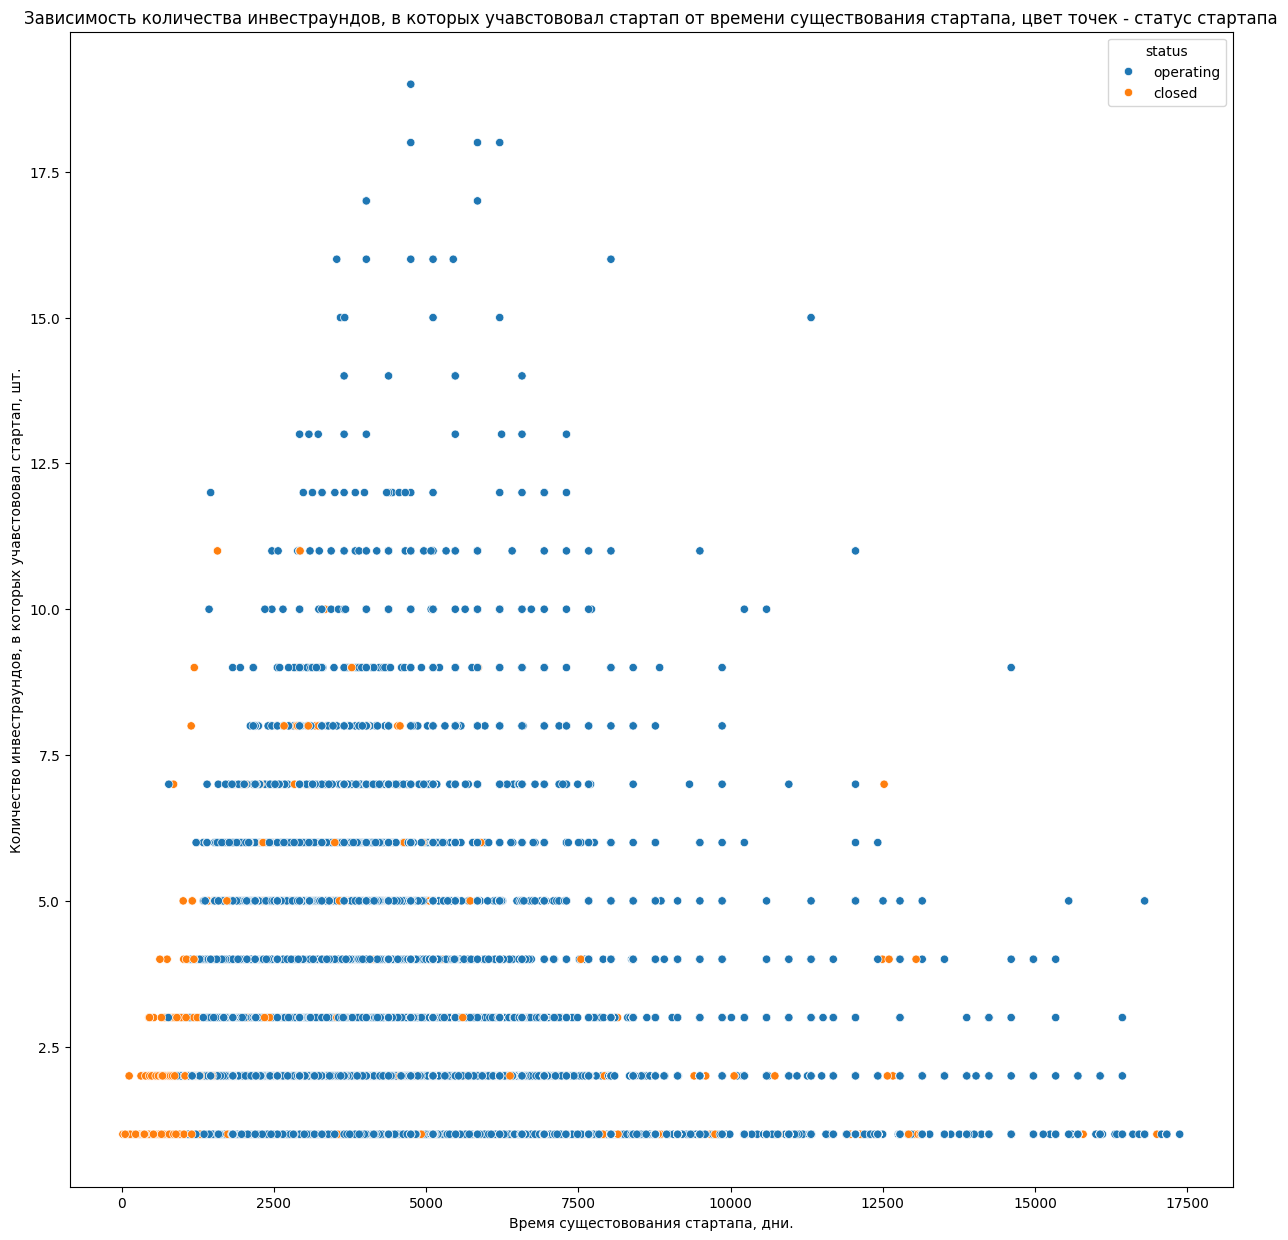

In [374]:
axes, fig = plt.subplots(figsize=(15,15))
sns.scatterplot(data=data_train, x='lifetime', y='funding_rounds', hue='status');
plt.xlabel('Время сущестовования стартапа, дни.');
plt.ylabel('Количество инвестраундов, в которых учавстововал стартап, шт.');
plt.title("Зависимость количества инвестраундов, в которых учавстововал стартап от времени существования стартапа, цвет точек - статус стартапа")

Как видно из графика выше, увеличение количества раундов инвестирования, в которых поучавстовала компания снижает вероятность ее закрытия.

In [375]:
data_train.head()

name        category_list  funding_total_usd     status  \
0               Lunchgate  Online Reservations           828626.0  operating   
1                 EarLens        Manufacturing         42935019.0  operating   
2  Reviva Pharmaceuticals        Biotechnology         35456381.0  operating   
3    Sancilio and Company          Health Care         22250000.0  operating   
4     WireTough Cylinders        Manufacturing          2000000.0  operating   

  country_code state_code       region          city  funding_rounds  \
0          CHE      Other       Zurich        Zürich               2   
1          USA         CA  SF Bay Area  Redwood City               4   
2          USA         CA  SF Bay Area      San Jose               3   
3      unknown    unknown      unknown       unknown               3   
4          USA         VA        Other       Bristol               1   

   first_funding_at  last_funding_at  lifetime  
0              2011             2014      2998  
1              2010             2014      4748  
2              2012             2014      4383  
3              2011             2014      5114  
4              2012             2012      2791

Оценим распределение долей закрывшихся стартапов, в зависимости от категории деятельности стартапа:

In [376]:
category_status_proportion = pd.DataFrame(
    data_train
    .groupby(['category_list'])['status']
    .value_counts(normalize=True)
    .reset_index()
    .query('status == "closed"')
)

In [377]:
category_high_risk = category_status_proportion.sort_values(by='proportion', ascending=False).head(10)

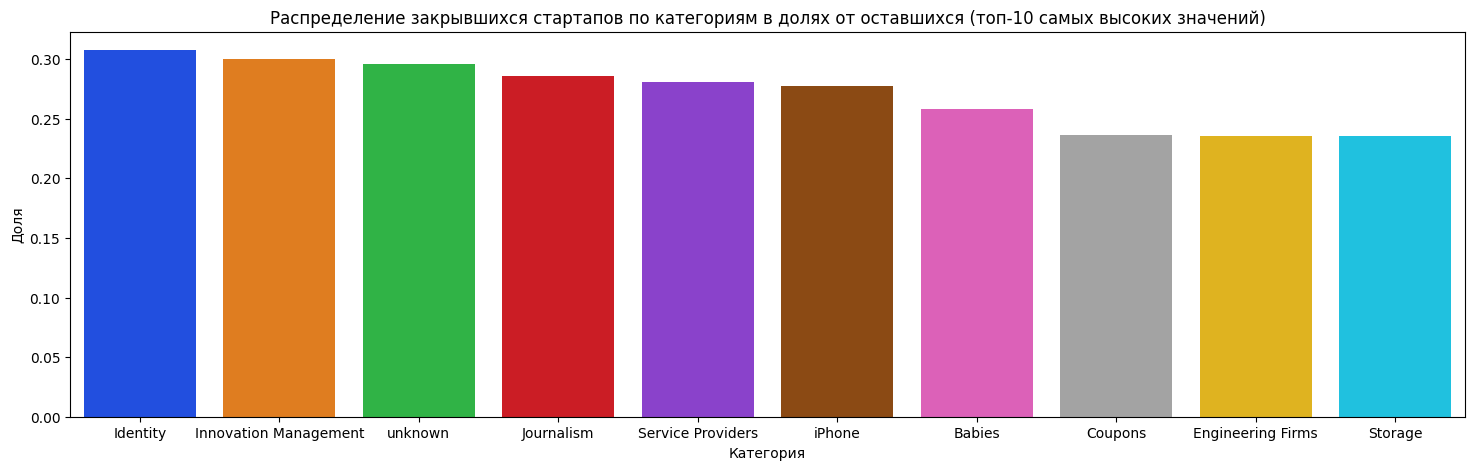

In [378]:
fig, axes = plt.subplots(figsize=(18,5))
sns.barplot(data=category_high_risk, x='category_list', y='proportion', palette='bright')

axes.set_xlabel('Категория')
axes.set_ylabel('Доля')
axes.set_title('Распределение закрывшихся стартапов по категориям в долях от оставшихся (топ-10 самых высоких значений)');

In [379]:
category_low_risk = category_status_proportion.sort_values(by='proportion').head(10)

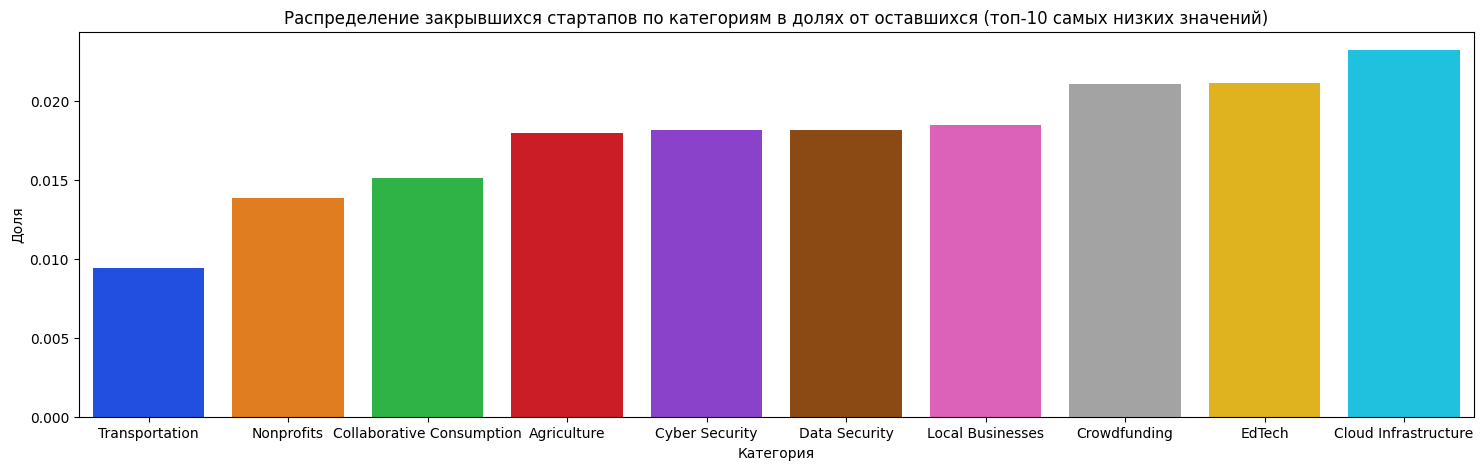

In [380]:
fig, axes = plt.subplots(figsize=(18,5))
sns.barplot(data=category_low_risk, x='category_list', y='proportion', palette='bright')

axes.set_xlabel('Категория')
axes.set_ylabel('Доля')
axes.set_title('Распределение закрывшихся стартапов по категориям в долях от оставшихся (топ-10 самых низких значений)');

Сформированы и выведены топ-10 сымых рискованных категорий деятельности стартапов (где доля закрывшихся компаний максимальна) и топ-10 самых безопасных категорий (где доля закрывшихся компаний минимальна) Оценим распределение долей закрывшихся стартапов, в зависимости от категории деятельности стартапа:

In [381]:
country_status_proportion = pd.DataFrame(
    data_train
    .groupby(['country_code'])['status']
    .value_counts(normalize=True)
    .reset_index()
    .query('status == "closed"')
)

In [382]:
country_high_risk = country_status_proportion.sort_values(by='proportion', ascending=False).head(10)

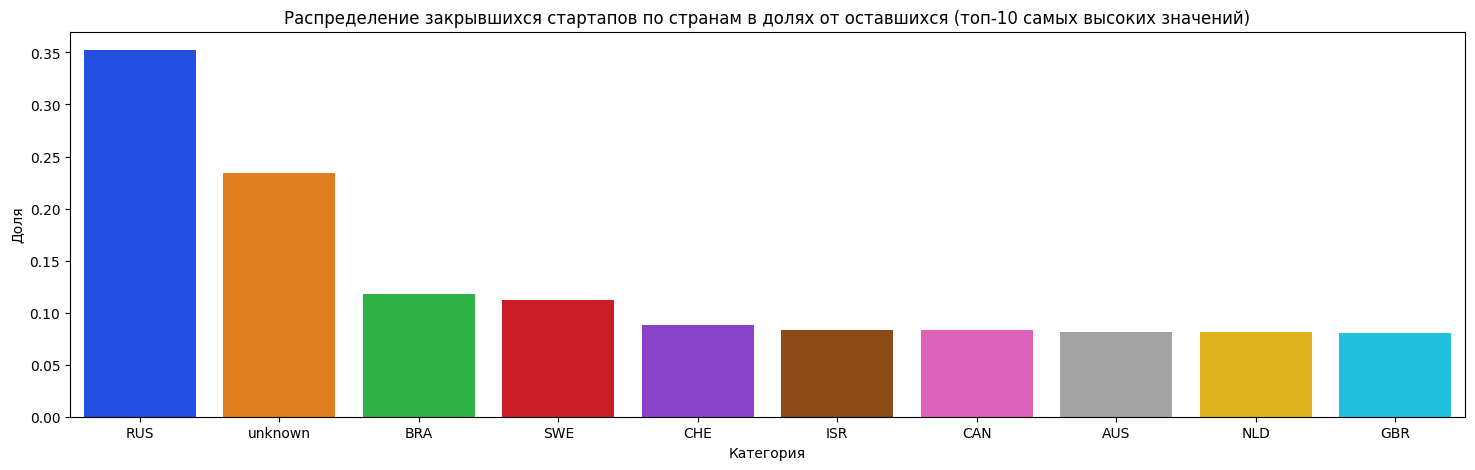

In [383]:
fig, axes = plt.subplots(figsize=(18,5))
sns.barplot(data=country_high_risk, x='country_code', y='proportion', palette='bright')

axes.set_xlabel('Категория')
axes.set_ylabel('Доля')
axes.set_title('Распределение закрывшихся стартапов по странам в долях от оставшихся (топ-10 самых высоких значений)');

In [384]:
country_low_risk = country_status_proportion.sort_values(by='proportion').head(10)

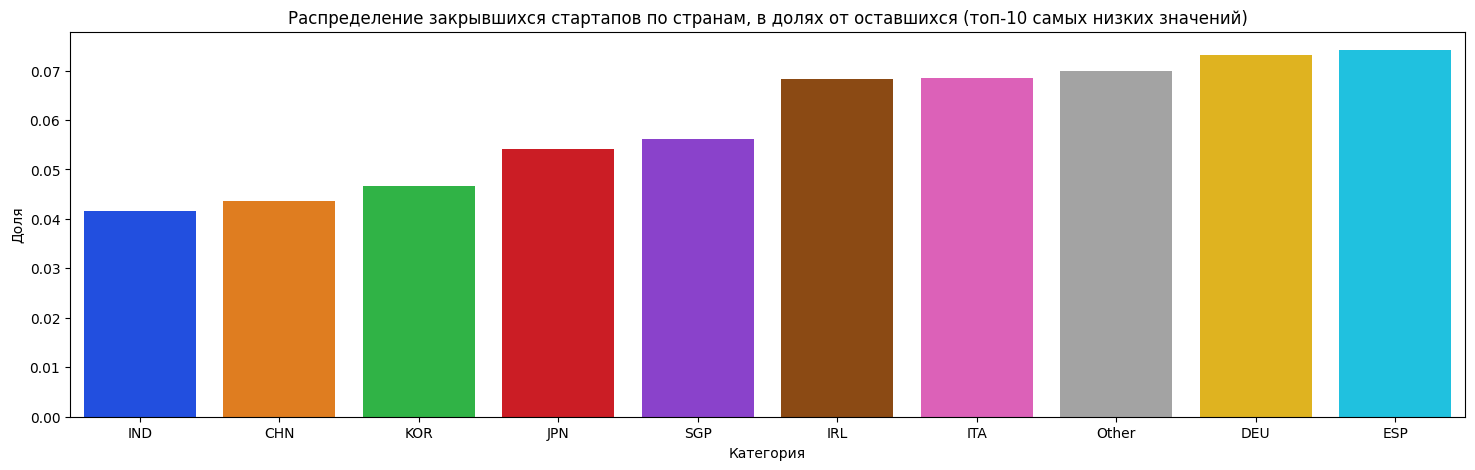

In [385]:
fig, axes = plt.subplots(figsize=(18,5))
sns.barplot(data=country_low_risk, x='country_code', y='proportion', palette='bright')

axes.set_xlabel('Категория')
axes.set_ylabel('Доля')
axes.set_title('Распределение закрывшихся стартапов по странам, в долях от оставшихся (топ-10 самых низких значений)');

Сформированы и выведены топ-10 самых рискованных стран регистрации стартапов (где доля закрывшихся компаний максимальна) и топ-10 самых безопасных стран (где доля закрывшихся компаний минимальна)

**Вывод:** В рамках данного раздела:
- изучено распределение количественных параметров. Параметр 'funding_total_usd' имеет выбросы в виде отличительно больших значений, однако эти данные реальны и их удаление приведет к искуственному регулированию данных. Также опытным путем установлено, что удаление выявленных выбросов, снижает искомую метрику f1.
- изучено распределение категориальных параметров. Выявлено, что  из за заполнения пропуков категорией 'unknown' и сокращения категорий за счет присваивания значения 'Other' непопулярным категориям, данные значения вышли в топ-категорий по количеству.
- сформированы графики рассеяния количественны признаков, относительно времени существования стартапа в днях. В качестве таргета пиняты значения столбца 'status'. Установлено что вероятность закрытия стартапа уменьшается с увеличением времени его существования, увеличением общей суммы инвестиций в стартап и увеличением количества раундов инвестирования, в которых поучавстовала рассматриваемая компания
- в распределении целевого признака имеется дисбаланс между категориями: количество объектов с параметром 'closed' составляет менее 10% от общего объема датасета.
- определены топ - 10 сымых рискованных и безопасных категорий деятельности стартапов.
- определены топ - 10 сымых рискованных и безопасных стран регистрации стартапов.

В целом существенных различий в распределении количественных и категориальных параметров тренировочной и тестовой выборок, не выявлено.

<a id='section_id4'></a>

# 4. Generation of new synthetic values

В качестве нового синтетического признака разработаем количественный параметр 'sint', который представляет собой произведение общей суммы финансирования ('funding_total_usd') и количества инвестраундов, в которых учавствовала компаняи ('funding_rounds'), деленное на время существования компании 'lifetime'. Данный признак отдельно выделяет компании имеющие небольшое время существование, но получившие большие суммы инвестиций.

In [386]:
data_train['sint'] = (data_train['funding_total_usd'] * data_train['funding_rounds'])  / data_train['lifetime']

In [387]:
data_test['sint'] =  (data_test['funding_total_usd']  * data_test['funding_rounds']) / data_test['lifetime']

Выведем первые пять строк, чтобы проверить корректность создания столбца:

In [388]:
data_train.head()

name        category_list  funding_total_usd     status  \
0               Lunchgate  Online Reservations           828626.0  operating   
1                 EarLens        Manufacturing         42935019.0  operating   
2  Reviva Pharmaceuticals        Biotechnology         35456381.0  operating   
3    Sancilio and Company          Health Care         22250000.0  operating   
4     WireTough Cylinders        Manufacturing          2000000.0  operating   

  country_code state_code       region          city  funding_rounds  \
0          CHE      Other       Zurich        Zürich               2   
1          USA         CA  SF Bay Area  Redwood City               4   
2          USA         CA  SF Bay Area      San Jose               3   
3      unknown    unknown      unknown       unknown               3   
4          USA         VA        Other       Bristol               1   

   first_funding_at  last_funding_at  lifetime    sint  
0              2011             2014      2998   552.8  
1              2010             2014      4748 36171.0  
2              2012             2014      4383 24268.6  
3              2011             2014      5114 13052.4  
4              2012             2012      2791   716.6

In [389]:
data_test.head()

name     category_list  funding_total_usd country_code  \
0              Crystalsol  Clean Technology          2819200.0        Other   
1        JBI Fish & Wings       Hospitality          2000000.0          USA   
2                COINPLUS           Finance           428257.0        Other   
3  Imagine Communications          Software         34700000.0          USA   
4                   DNA13          Software          4530000.0          CAN   

  state_code     region       city  funding_rounds  first_funding_at  \
0      Other    unknown    unknown               1              2009   
1         TN      Other      Other               1              2010   
2      Other      Other      Other               2              2014   
3         CA  San Diego  San Diego               4              2005   
4         ON     Ottawa     Ottawa               1              2007   

   last_funding_at  lifetime    sint  
0             2009      3501   805.3  
1             2010      2717   736.1  
2             2014      1295   661.4  
3             2010      4748 29233.4  
4             2007      6209   729.6

Изучим распределение вновь созданного параметра.

count      52516.0
mean       14443.7
std       199348.5
min            0.0
25%          273.8
50%         1026.5
75%         3786.7
max     33053547.1
Name: sint, dtype: float64

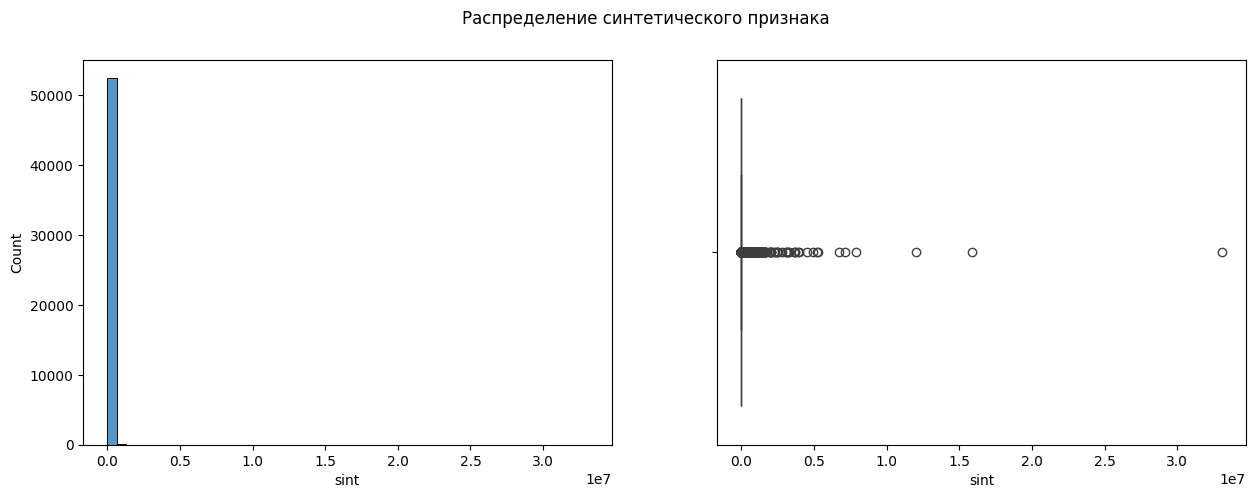

In [390]:
num_stat_and_graph(data_train, 'sint', 50, 'Распределение синтетического признака')

count      13125.0
mean       13494.7
std       152754.0
min            0.0
25%          271.1
50%         1005.4
75%         3717.5
max     10016868.9
Name: sint, dtype: float64

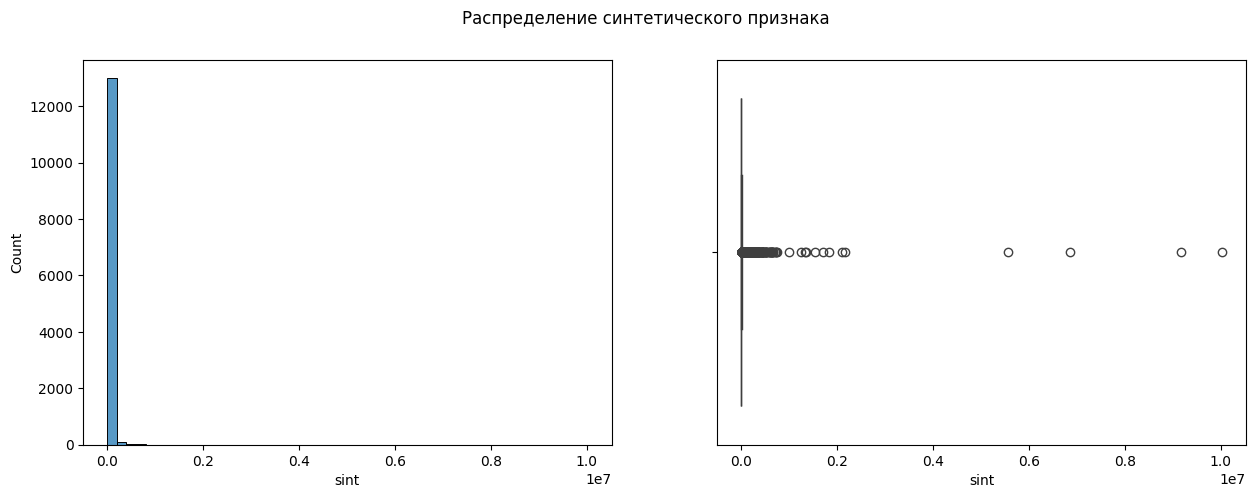

In [391]:
num_stat_and_graph(data_test, 'sint', 50, 'Распределение синтетического признака')

Чтобы графики были читаемыми, избавим параметр от экстремально высоких значений

In [392]:
data_train2 = data_train[data_train['sint'] < 10_000]

In [393]:
data_test2 = data_test[data_test['sint'] < 10_000]

count   44608.0
mean     1500.8
std      1998.8
min         0.0
25%       195.6
50%       763.9
75%      1810.0
max      9993.9
Name: sint, dtype: float64

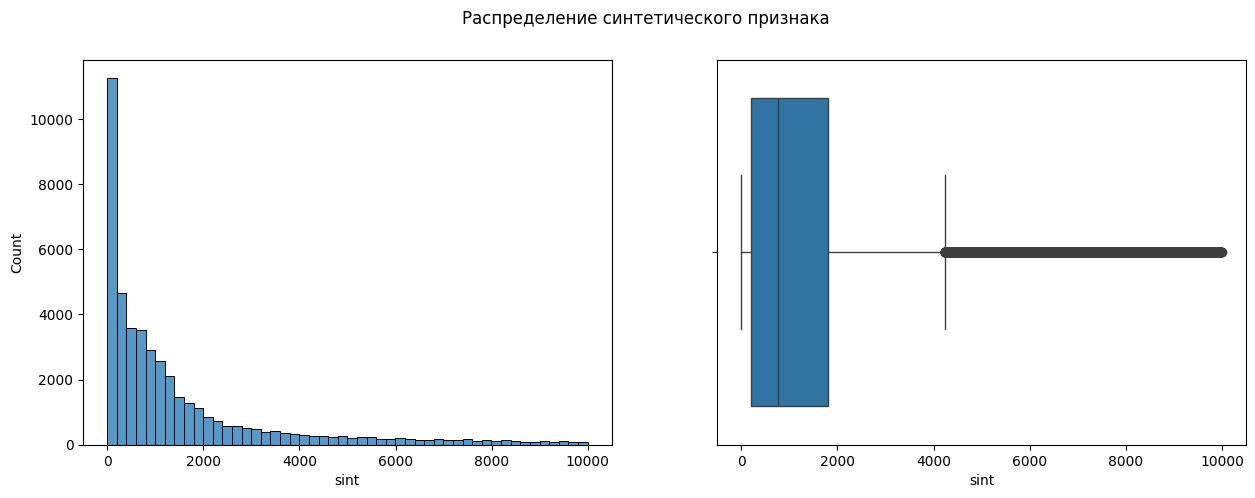

In [394]:
num_stat_and_graph(data_train2, 'sint', 50, 'Распределение синтетического признака')

count   11194.0
mean     1504.7
std      2001.7
min         0.0
25%       194.9
50%       761.8
75%      1824.8
max      9999.6
Name: sint, dtype: float64

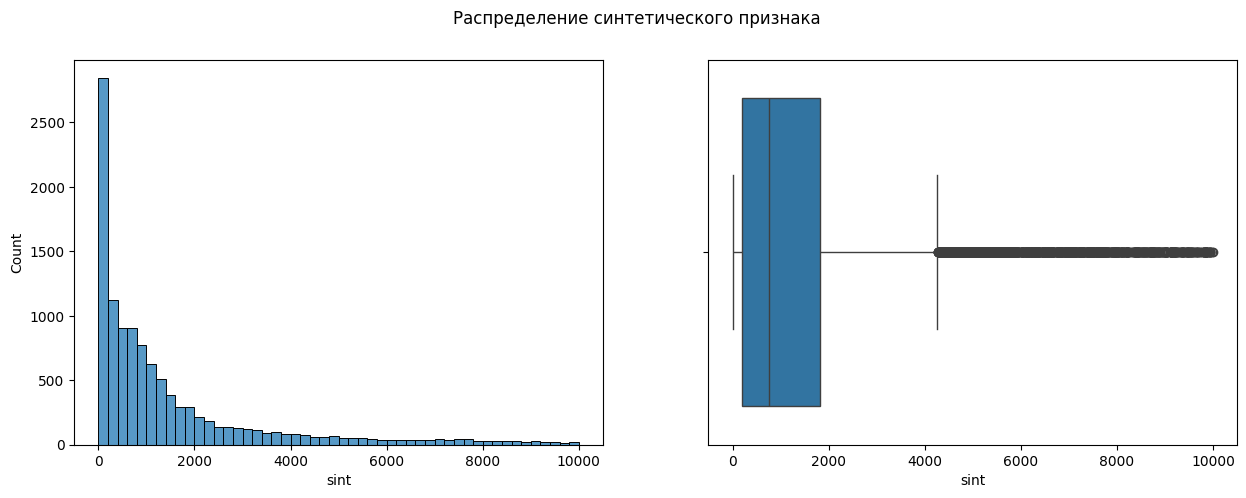

In [395]:
num_stat_and_graph(data_test2, 'sint', 50, 'Распределение синтетического признака')

Как видно на графике, большая доля стартапов имеет распределение значения синтетического признака в районе 0 с дальнейшим снижением. Выведем график рассеяния относительно времени существования стратпа с таргетом 'status' **Вывод:** разработан новый синтетический признак 'sint', который представляет собой произведение общей суммы финансирования ('funding_total_usd') и количества инвестраундов, в которых учавствовала компаняи ('funding_rounds'), деленное на время существования компании 'lifetime'.

Изучено распределение данного параметра - существенную долю составляют нулевые значения с последующи плавно снижающимся правым "хвостом"   

# 5. Multicollinearity check

Проверим на мультиколлинеарность количественные признаки датасета, путем составляения матрицы корреляции. Так как в имеющемся датасете отсутствуют нормально распределенные параметры, при составлении матрицы корреляции будем использвать коэффициент Спирмена. Phik матрицу использовать не будем, т.к. при имеющемся количестве категориальных значений ее вычисление требует значительных временных  ресурсов

In [396]:
corr_spearman = data_train.corr(method='spearman', numeric_only=True)

In [397]:
corr_spearman

funding_total_usd  funding_rounds  first_funding_at  \
funding_total_usd                1.0             0.4              -0.3   
funding_rounds                   0.4             1.0              -0.3   
first_funding_at                -0.3            -0.3               1.0   
last_funding_at                 -0.1             0.2               0.8   
lifetime                         0.4             0.2              -0.6   
sint                             0.9             0.6              -0.2   

                   last_funding_at  lifetime  sint  
funding_total_usd             -0.1       0.4   0.9  
funding_rounds                 0.2       0.2   0.6  
first_funding_at               0.8      -0.6  -0.2  
last_funding_at                1.0      -0.4   0.1  
lifetime                      -0.4       1.0   0.1  
sint                           0.1       0.1   1.0

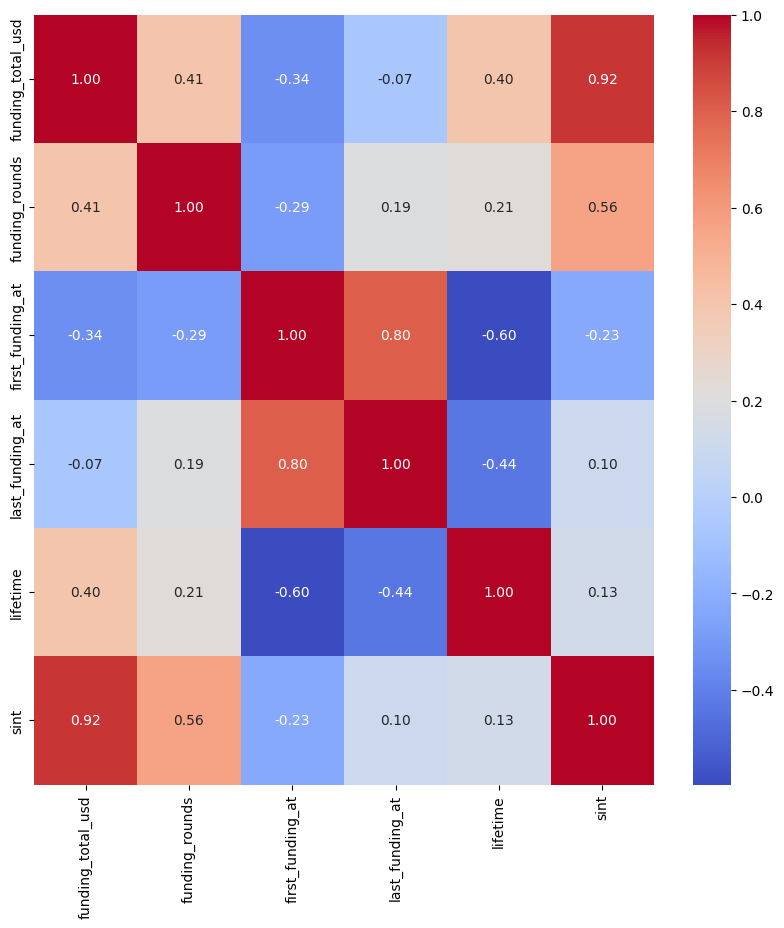

In [398]:
ax, fig = plt.subplots(figsize=(10,10))
sns.heatmap(corr_spearman, annot=corr_spearman, cmap='coolwarm', fmt='.2f',  annot_kws={"size":10});

**Вывод:** Выполнена проверка на мультиколлинеарность путем составления матрицы корреляции.  
В соответствии со шкалой Чеддока, в датасете имеются следующие зависимости:
- слабая связь между параметрами 'funding_rounds' и 'lifetime', а также 'delta_funding_days' и 'lifetime'
- умеренная связь между 'funding_rounds' и 'funding_total_usd', 'lifetime' и ,  а также 'delta_funding_days' и  'funding_total_usd'
- весьма высокая связь между 'funding_rounds' и 'delta_funding_days'.

# 6. Selecting final set of training objects

В качестве финального набора будем использовать следующие входные признаки:
- количественные: 'funding_total_usd', 'lifetime', 'delta_funding_days', 'funding_rounds'
- категориальные: 'country_code', 'category_list', 'state_code', 'city'

Для обучения моделей не будут использоваться признаки:

- категориальные: 'name'(по сути является индексом и не обучает модель), 'status'(целевой признак), 'region'(отфильтрован опытнвм путем. как признак не повышающий метрику)
- количественные: 'first_funding_at', 'last_funding_at' (удалены, т.к. признак 'delta_funding_days' создан на основе их разности)

**Вывод:** В качестве финального набора отобраны следующие входные признаки:
- количественные: 'funding_total_usd', 'lifetime', 'delta_funding_days', 'funding_rounds'
- категориальные: 'country_code', 'category_list', 'state_code', 'city'

# 7. Choosing and fitting models

В связи с тем, что в тренировочном датасете имеется дисбаланс значений целевого признака, проведем оверсэмплинг вручную:

In [399]:
delta = data_train['status'].value_counts()['operating'] - data_train['status'].value_counts()['closed']

In [400]:
sampled_closed = data_train.query("status=='closed'").sample(delta, replace=True)

In [401]:
df_sampled = pd.concat([data_train, sampled_closed])

In [402]:
df_sampled = df_sampled.sample(frac=1)

Выведем общую информацию о сэмплированном тренировочном датасете:

In [403]:
df_sampled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95198 entries, 16766 to 27665
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               95198 non-null  object 
 1   category_list      95198 non-null  object 
 2   funding_total_usd  95198 non-null  float64
 3   status             95198 non-null  object 
 4   country_code       95198 non-null  object 
 5   state_code         95198 non-null  object 
 6   region             95198 non-null  object 
 7   city               95198 non-null  object 
 8   funding_rounds     95198 non-null  int64  
 9   first_funding_at   95198 non-null  int64  
 10  last_funding_at    95198 non-null  int64  
 11  lifetime           95198 non-null  int64  
 12  sint               95198 non-null  float64
dtypes: float64(2), int64(4), object(7)
memory usage: 10.2+ MB


Выведем первые 5 строк сэмплированного датасета:

In [404]:
df_sampled.head()

name   category_list  funding_total_usd     status country_code  \
16766       Evant  Consumer Goods         15000000.0  operating          USA   
45885  Roboinvest     Curated Web           125000.0  operating          USA   
43677   BioWizard     Curated Web          1100000.0     closed          USA   
23493    Wildfire     Advertising         14100000.0  operating          USA   
41199   Shoot it!       Messaging           200000.0  operating          USA   

      state_code         region           city  funding_rounds  \
16766         CA    SF Bay Area  San Francisco               1   
45885         NY  New York City       New York               1   
43677         PA   Philadelphia          Wayne               2   
23493         CA    SF Bay Area   Redwood City               4   
41199         AZ        Phoenix     Scottsdale               1   

       first_funding_at  last_funding_at  lifetime    sint  
16766              2004             2004      8766  1711.2  
45885              2012             2012      2653    47.1  
43677              2007             2008      1368  1608.2  
23493              2008             2011      3471 16248.9  
41199              2009             2009      3600    55.6

Выведем итоговое количество объектов содержащие в себе различные значения целевого признака:

In [405]:
df_sampled['status'].value_counts()

status
operating    47599
closed       47599
Name: count, dtype: int64

Для обучения и последующего прогнозирования целевого признака будем использовать пайплайн соследующими параметрами:
- масштабирование: StandardScaler(), MinMaxScaler(), RobustScaler()
- кодирование: OneHotEncoder(), OrdinalEncoder()
- обработка неизвестных значений:  SimpleImputer()
- модели:  KNeighborsClassifier(), RandomForestClassifier(), CatBoostClassifier()

In [406]:
X = df_sampled.drop(['name', 'status', 'region'],  axis=1)
y = df_sampled['status']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify = y
)


cat_columns = ['country_code', 'category_list', 'state_code', 'city']
num_columns = ['funding_total_usd', 'lifetime',  'funding_rounds', 'first_funding_at', 'last_funding_at', 'sint']

ohe_pipe = Pipeline(
    [('simpeImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ]
)


data_preprocessor = ColumnTransformer(
    [('cat', ord_pipe, cat_columns),
    ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [407]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

param_grid = [

    {
        'models': [KNeighborsClassifier()],
        'preprocessor__cat': [ohe_pipe, ord_pipe, 'passthrough'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },

     {
        'models': [RandomForestClassifier(
         random_state=RANDOM_STATE
        )],
        'preprocessor__cat': [ohe_pipe, ord_pipe, 'passthrough'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },


    {
        'models': [CatBoostClassifier(silent=True)],
        'preprocessor__cat': [ohe_pipe, ord_pipe, 'passthrough'],
        'preprocessor__num': [StandardScaler(),  'passthrough']
    }
]

f1_scorer = make_scorer(f1_score, pos_label="closed")

grid_search = GridSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring=f1_scorer,
    n_jobs=-1
)


grid_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print('Лучшая метрика на кросс-валидационной выборке:', grid_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('simpeImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['country_code',
                                                   'category_list',
                                                   'state_code', 'city']),
                               

**Вывод:** По результату обучения на тренировочной выборке, определены следующие парааметры модели/пайплайна, формирующие наилучшие результаты на кросс-валидационной выборке:

- масштабирование: RobustScaler()
- кодирование:  OneHotEncoder()
- обработка неизвестных значений: SimpleImputer()
- модель:  RandomForestClassifier()
- метрика на кросс-валидационной выборке: 0.996

#8. Final prediction based on best model

С помощью лучшей модели, полученной с помощью пайплайна, спрогнозируем целевой признак на тестовой выборке:

In [408]:
y_test_pred =  grid_search.best_estimator_.predict(X_test)

На основании прогнозных данных, расчитаем метрику f1:

In [409]:
f1_score(y_test, y_test_pred, pos_label='closed')

0.996024272860431

**Вывод:** На основании лучшей модели, полученной при обучении модели получена метрика на тестовой выборке, составляющая f1 = 0.996


# 9. Analyzing the importance of the features of the best model

Оценим важность признаков, для модели с наилучшими значениями метрик, полученной в разделе выше и построим график важности с помощью метода SHAP: Применим лучшую модель, полученную по итогам работы пайплайна:

In [410]:
model = grid_search.best_estimator_

In [411]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('simpeImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['country_code',
                                                   'category_list',
                                                   'state_code', 'city']),
                                                 ('num', RobustScaler(),
                                                  ['funding_total_usd',
                                                   'lifetime', 'funding_rounds',
                                                   'first_funding_at',
                                                   'last_funding_at',
                                                   'sint'])])),
                ('models', RandomForestClassifier(random_state=42))])

Обучим и преобразуем массив X_train:

In [412]:
model['preprocessor'].fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat',
                                 Pipeline(steps=[('simpeImputer_ohe',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['country_code', 'category_list', 'state_code',
                                  'city']),
                                ('num', RobustScaler(),
                                 ['funding_total_usd', 'lifetime',
                                  'funding_rounds', 'first_funding_at',
                                  'last_funding_at', 'sint'])])

In [413]:
X_train_preprocessed = model['preprocessor'].transform(X_train)

Выделим имена столбцов массива X_train, полученные после преобразования кодировщиком и скейлером:

In [414]:
column_names = model['preprocessor'].get_feature_names_out()

In [415]:
data = pd.DataFrame(X_train_preprocessed, columns=column_names)

In [416]:
explainer = shap.TreeExplainer(model['models'], data=data)
shap_values = explainer(data, check_additivity=False )

100%|===================| 142791/142796 [240:49<00:00]       

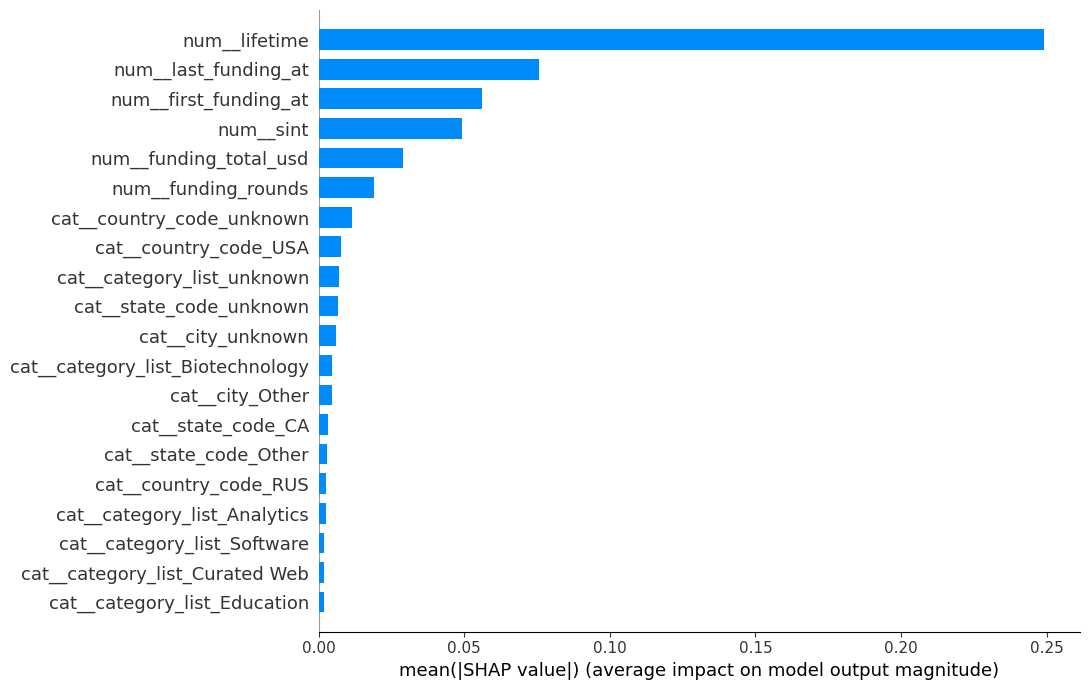

In [417]:
shap.summary_plot(shap_values[:,:,1], data,  plot_type='bar', plot_size = (11,7))

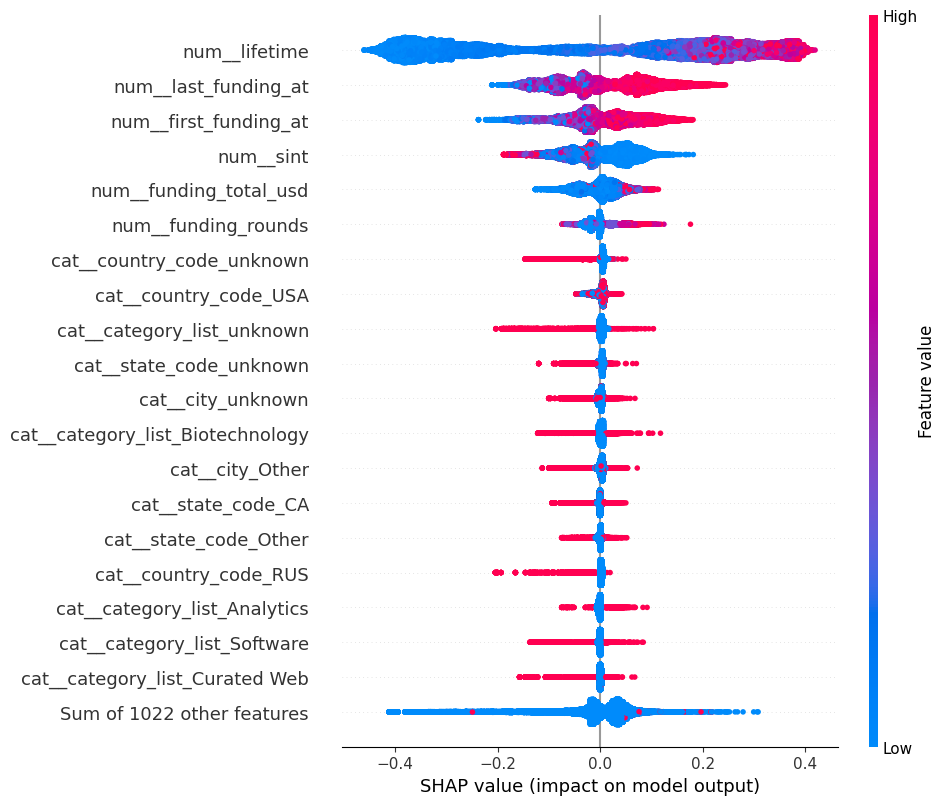

In [418]:
shap.plots.beeswarm(shap_values[:,:,1], max_display=20)

**Вывод:** По результатам анализа полученных графиков, можно прийти к следующим выводам:
Возьмем за границу, разделяющую важные признаки от неважных - среднее значение Шепли, равные 0.05.
Тогда получим, что:
- менее на прогноз целевого признака влияют следующие входные параметры: 'funding_total_usd', 'funding_rounds', 'country_code', 'category_list', 'state_code', 'city';
- более всего на прогноз целевого признака влияют следующие входные параметры: 'first_funding_at', 'sint', 'last_funding_at',  'lifetime'.

На основании описанного выше, для повышения надежности инвестиций рекомендуется инвестировать в компании которые существуют на рынке более 7 лет и имеют общую сумму инвестиций более 2 000 000 USD
<a id='section_id9'></a>

# 10. General conclusion

Целью настоящего исследования является разработка модели, предсказывающей вероятность закрытия того или иного стартапа, на основании данных о стартапах, функционировавших в период с 1970 по 2018 годы.

Необходимые для исследования данные загружены, проверены на корректность отображения, также выведены основные статистические параметры датасетов.

В рамках предварительной обработки:
- выявлены и обработаны пропуски в количественных и категориальных данных;
- тренировочный датасет проверен на наличие явных дубликатов и дубликатов по названию компании;
- значения, отображающие даты событий, переведены из строкового формата в формат datetime;
- сокращено количество уникальных значений категориальных признаков, для улучшения обобщающей способности модели

В рамках разведочного анализа:

- изучено распределение количественных параметров. Параметр 'funding_total_usd' имеет выбросы в виде отличительно больших значений, однако эти данные реальны и их удаление приведет к искуственному регулированию данных. Также опытным путем установлено, что удаление выявленных выбросов, снижает искомую метрику f1.
- изучено распределение категориальных параметров. Выявлено, что из за заполнения пропуков категорией 'unknown' и сокращения категорий за счет присваивания значения 'Other' непопулярным категориям, данные значения вышли в топ-категорий по количеству.
- сформированы графики рассеяния количественны признаков, относительно времени существования стартапа в днях. В качестве таргета пиняты значения столбца 'status'. Установлено что вероятность закрытия стартапа уменьшается с увеличением времени его существования, увеличением общей суммы инвестиций в стартап и увеличением количества раундов инвестирования, в которых поучавстовала рассматриваемая компания
- в распределении целевого признака имеется дисбаланс между категориями: количество объектов с параметром 'closed' составляет менее 10% от общего объема датасета.  
- определены топ - 10 сымых рискованных и безопасных категорий деятельности стартапов.
- определены топ - 10 сымых рискованных и безопасных стран регистрации стартапов.
В целом существенных различий в распределении количественных и категориальных параметров тренировочной и тестовой выборок, не выявлено.

Разработан новый синтетический признак 'sint', который представляет собой произведение общей суммы финансирования ('funding_total_usd') и количества инвестраундов, в которых учавствовала компаняи ('funding_rounds'), деленное на время существования компании 'lifetime'.

Выполнена проверка на мультиколлинеарность путем составления матрицы корреляции.  
В соответствии со шкалой Чеддока, в датасете имеются следующие зависимости:
- слабая связь между параметрами 'funding_rounds' и 'lifetime', а также 'delta_funding_days' и 'lifetime'
- умеренная связь между 'funding_rounds' и 'funding_total_usd', 'lifetime' и ,  а также 'delta_funding_days' и  'funding_total_usd'
- весьма высокая связь между 'funding_rounds' и 'delta_funding_days'.

В качестве финального набора отобраны следующие входные признаки:
- количественные: 'funding_total_usd', 'lifetime', 'delta_funding_days', 'funding_rounds'
- категориальные: 'country_code', 'category_list', 'state_code', 'city'

По результату обучения на тренировочной выборке, определены следующие парааметры модели/пайплайна, формирующие наилучшие результаты на кросс-валидационной выборке:

- масштабирование: RobustScaler()
- кодирование: OneHotEncoder()
- обработка неизвестных значений: SimpleImputer()
- модель: RandomForestClassifier()
- метрика на кросс-валидационной выборке: 0.996

На основании лучшей модели, полученной при обучении модели получена метрика на тестовой выборке, составляющая f1 = 0.996

По результатам важности признаков лучшей модели, можно прийти к следующим выводам:
- менее на прогноз целевого признака влияют следующие входные параметры: 'funding_total_usd', 'funding_rounds', 'country_code', 'category_list', 'state_code', 'city';
- более всего на прогноз целевого признака влияют следующие входные параметры: 'first_funding_at', 'sint', 'last_funding_at',  'lifetime'.

На основании описанного выше, для повышения надежности инвестиций рекомендуется инвестировать в компании которые существуют на рынке более 7 лет и имеют общую сумму инвестиций более 2 000 000 USD. Топ - 10 сымых рискованных и безопасных категорий деятельности и стран регистрации стартапов определены на графиках в разделе